# Title: Pt film grain detection
author: Nikolay Chehlarov

email: chehlarow@yahoo.com

git: https://github.com/Chehlarov

date: 18.11.2021.

Abstract:
This work describes the development of an algorithm for image segmentation. The goal is to detect Pt grains from SEM images and perform statistical analysis. The algorithm includes a machine learning model based on XGBoost and post-processing using watershed. F1 score above 0.8 was achieved  and the delivered results are with enough quality.

In [1]:
import os
import sys
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import ndimage
from scipy.ndimage.interpolation import rotate

from skimage import io, color, measure
import skimage.filters as filters
from skimage.restoration import denoise_tv_chambolle  
from skimage.filters import edges

from skimage.feature import peak_local_max
from skimage.segmentation import clear_border, watershed
from skimage import util
from skimage.morphology import disk, binary_closing, binary_dilation, flood_fill
from skimage import exposure
from skimage.util import img_as_float32, img_as_uint, img_as_ubyte, random_noise
from skimage import draw
from skimage.exposure import match_histograms

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, learning_curve
from sklearn import metrics
from sklearn.metrics import recall_score, f1_score, precision_score 
from sklearn.utils import shuffle

import xgboost as xgb

# Problem definition

### Background
Pt films are used in engineering for various purposes. For example for temperature or strain sensing. The distribution of grain sizes is an important property for the product function. Non ML based approaches failed to achieve acceptable results.

### Goal
Create an algorithm to perform image segmentation of Pt grains from a SEM image. Demonstrate statistical analysis for the grain sizes.

# Feature extraction

## Filter selection

Several filters can be used to generate features for ML. Selecting the right ones is critical for the performance of the algorithm. In this section demonstration of the filters will be shown. The feature selection is iterative process and requires domain knowledge. 

Some filter comments:
- Roberts Cross - amplifies noise more than Sobel
- Prewitt gradient: very similar way to the Sobel, but is not as isotropic in its response. 
- Laplacian (laplace) - approximates second derivative
- difference_of_gaussians - similar to Laplacian

Feature groups, information flow into the ML:
- the value of pixel itself (after some filter)
- information from neighbors:
    - indirectly: most filters include kernels and neighboring pixels affect the value of the pixel itself. The kernel size might appear small
    - directly: pixel values of neighbors, or difference like center pixel - neighbor pixel

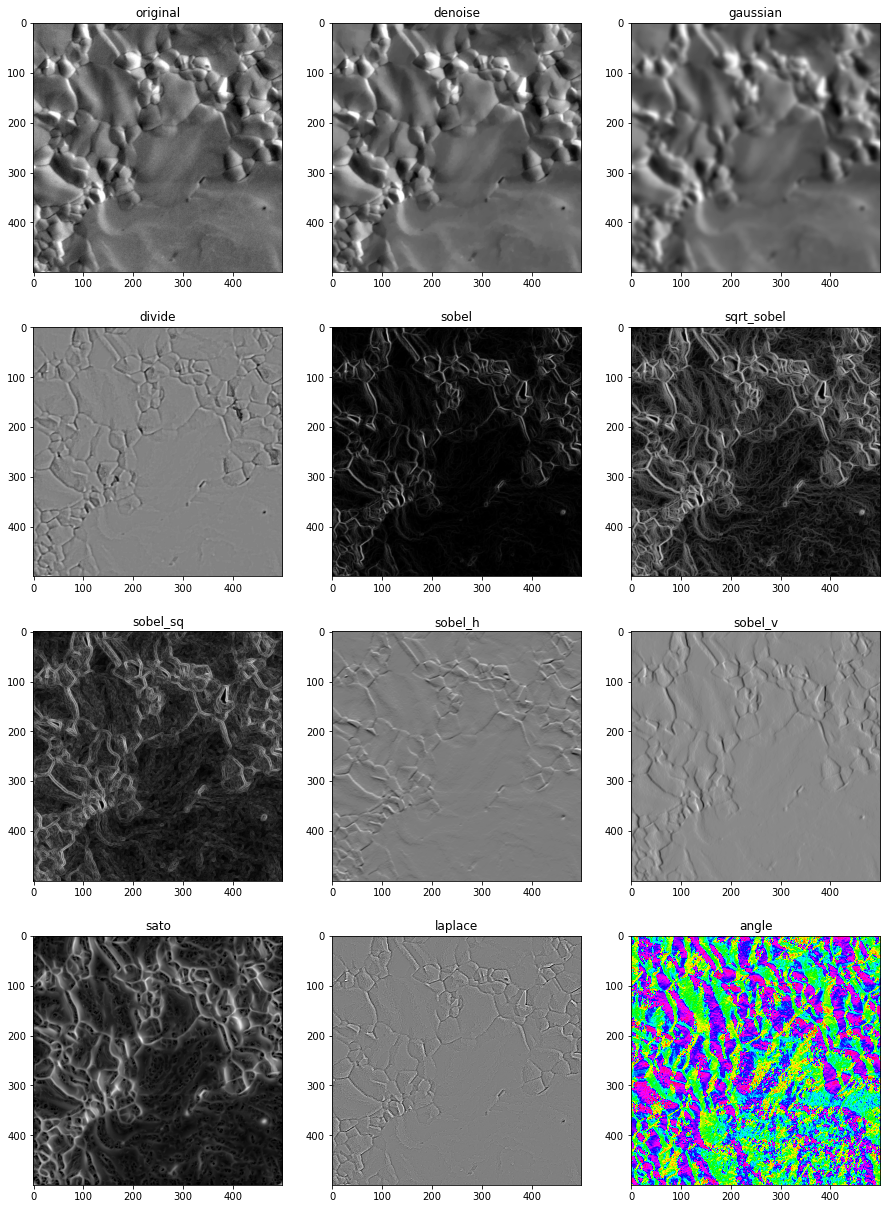

In [2]:
# preview of diffrent filters
img = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:500, 0:500]   
img = img_as_float32(img)
img_mask = io.imread(r"train_test_images/full_image_mask.tif", as_gray=True)[0:500, 0:500]   
mask = img_mask.astype(bool) 

plt.figure(figsize=(12, 18))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.2)

plt.subplot(4, 3, 1)
plt.imshow(img, cmap="gray")
plt.title(f"original")

denoise = denoise_tv_chambolle(img, weight=0.03, eps=0.00000002, n_iter_max=2000)  
plt.subplot(4, 3, 2)
plt.imshow(denoise, cmap="gray")
plt.title(f"denoise")

gaussian = cv2.GaussianBlur(denoise, (9,9), 50)
plt.subplot(4, 3, 3)
plt.imshow(gaussian, cmap="gray")
plt.title(f"gaussian")

divide = cv2.divide(denoise, gaussian, scale=0.5) 
plt.subplot(4, 3, 4)
plt.imshow(divide, cmap="gray")
plt.title(f"divide")   

sobel = filters.sobel(denoise)
plt.subplot(4, 3, 5)
plt.imshow(sobel, cmap="gray")
plt.title(f"sobel")  

sqrt_sobel = np.sqrt(sobel)
plt.subplot(4, 3, 6)
plt.imshow(sqrt_sobel, cmap="gray")
plt.title(f"sqrt_sobel")

sobel_sq = filters.sobel(sobel)
sobel_sq = np.sqrt(sobel_sq)
plt.subplot(4, 3, 7)
plt.imshow(sobel_sq, cmap="gray")
plt.title(f"sobel_sq")

sobel_h = filters.sobel_h(denoise)
plt.subplot(4, 3, 8)
plt.imshow(sobel_h, cmap="gray")
plt.title(f"sobel_h")
    
sobel_v = filters.sobel_v(denoise)
plt.subplot(4, 3, 9)
plt.imshow(sobel_v, cmap="gray")
plt.title(f"sobel_v")

sato = filters.sato(divide, mode='constant')
sato = np.sqrt(sato)
plt.subplot(4, 3, 10)
plt.imshow(sato, cmap="gray")
plt.title(f"sato")

laplace = filters.laplace(denoise)
plt.subplot(4, 3, 11)
plt.imshow(laplace, cmap="gray", vmin=-0.2, vmax=0.2)
plt.title(f"laplace")

# angle is cycling feature and cannot be used directly; for example 1 and -1 are the same directions
# maybe use diffrece to neighbours (or add two features sin(a) and cos(a))
# low angle diffrence to neighbours is a sign that the gradient is uniform/laminar
angle = np.arctan2(sobel_v, sobel_h) / np.pi
plt.subplot(4, 3, 12)
plt.imshow(angle, cmap="hsv") # use cycling colormap
plt.title(f"angle")

plt.show()

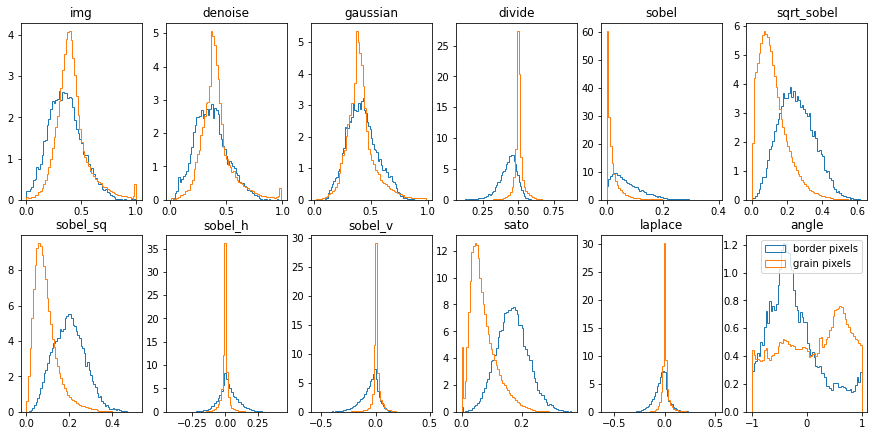

In [3]:
#histograms
img_data = [img, denoise, gaussian, divide, sobel, sqrt_sobel, sobel_sq, sobel_h, sobel_v, sato, laplace, angle]
img_labels = ['img', 'denoise', 'gaussian', 'divide', 'sobel', 'sqrt_sobel', 'sobel_sq', 'sobel_h', 'sobel_v', 'sato', 'laplace', 'angle']
plt.figure(figsize=(12, 6))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.2)
i = 1
for el, name in zip(img_data, img_labels):
    plt.subplot(2, 6, i)
#     plt.hist(el.ravel(), bins=64, histtype="step", density=True, label="all")
    el2 = el.copy()
    el2[~mask] = np.nan
    plt.hist(el2.ravel(), bins=64, histtype="step", density=True, label="border pixels")
    el2 = el.copy()
    el2[mask] = np.nan
    plt.hist(el2.ravel(), bins=64, histtype="step", density=True, label="grain pixels")
    plt.title(name)
    i += 1
    
plt.legend()
plt.show()

Some of the filters indicate significant difference of the border and grain pixels - a good sign. Several filters produce similar histograms. The next cell evaluates the correlation.

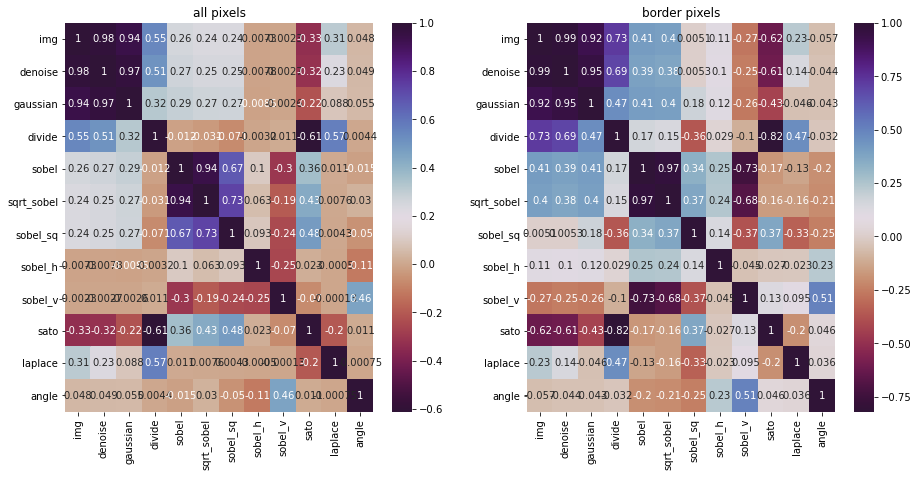

In [4]:
df = pd.DataFrame()
for pic, name in zip(img_data, img_labels):
    s = pd.Series(pic.ravel(), name=name)
    df = pd.concat([df, s], axis=1)
    
df_borders = pd.DataFrame()
for pic, name in zip(img_data, img_labels):
    temp = pic.copy()
    temp[~mask] = np.nan
    s = pd.Series(temp.ravel(), name=name)
    df_borders = pd.concat([df_borders, s], axis=1)
    
cor = df.corr()
cor_borders = df_borders.corr()
plt.figure(figsize=(12, 6))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.2)

plt.subplot(1, 2, 1)
sns.heatmap(cor, annot=True, cmap=plt.cm.twilight_shifted_r)
plt.title("all pixels")

plt.subplot(1, 2, 2)
sns.heatmap(cor_borders, annot=True, cmap=plt.cm.twilight_shifted_r)
plt.title("border pixels")
plt.show()

There are high correlations between some proposed features. 

Selected features:
- denoise : selected as representative of img and gaussian; the advantage over img is removed noise; it is very close to img, the primary information carrier
- divide
- sqrt_sobel : preferred over sobel, because avoids crowding of values at 0
- sobel_sq : gives similar distribution as sqrt_sobel, but the correlation between them is quite low
- sobel_h
- sobel_v : some correlation to sobel is seen, but such correlation doesn't exist between sobel_h; from symmetry point of view _h and _v will be included
- sato
- laplace

Not selected:
- angle : needs conversion to account for the cycling behavior of such feature; for example sin(angle) and cos(angle) could be used as features. Other option is to obtain the absolute difference of angle between center pixels and neighbors. The angle value at certain pixel doesn't give any information whether it is border or not

## Filters with high neighbor influence

The above demonstrated filters have relatively small kernels. They do not give indication for the surrounding for the pixel of interest. To add information for the surroundings, custom, larger kernels will be created and applied.

In [5]:
img_test = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:560, 0:625]
img_test = img_test[250:320, 370:450]
# img_test = np.flip(img_test, axis=1)
denoise = denoise_tv_chambolle(img_test, weight=0.03, eps=0.00000002, n_iter_max=2000)  
gaussian = cv2.GaussianBlur(denoise, (9,9), 50)
divide = cv2.divide(denoise, gaussian, scale=0.5) 

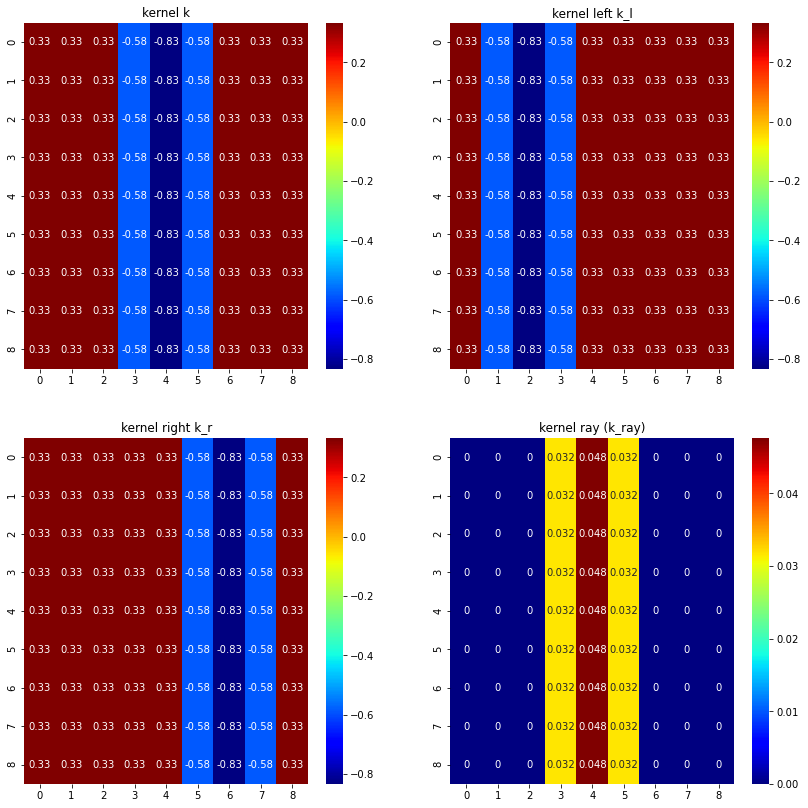

In [6]:
# preview of the used kernels
k = np.array([[1, 1, 1, -1.75, -2.5, -1.75, 1, 1, 1]] *9) / 3
k_l = np.array([[1, -1.75, -2.5, -1.75, 1, 1, 1, 1, 1]] *9) / 3
k_r = np.array([[1, 1, 1, 1, 1, -1.75, -2.5, -1.75, 1]] *9) / 3
k_ray = np.array([[0, 0, 0, 2, 3, 2, 0, 0, 0]] * 9) / 63

plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.heatmap(k, annot=True, cmap=plt.cm.jet)
plt.title("kernel k")

plt.subplot(2, 2, 2)
sns.heatmap(k_l, annot=True, cmap=plt.cm.jet)
plt.title("kernel left k_l")

plt.subplot(2, 2, 3)
sns.heatmap(k_r, annot=True, cmap=plt.cm.jet)
plt.title("kernel right k_r")

plt.subplot(2, 2, 4)
sns.heatmap(k_ray, annot=True, cmap=plt.cm.jet)
plt.title("kernel ray (k_ray)")

plt.show()

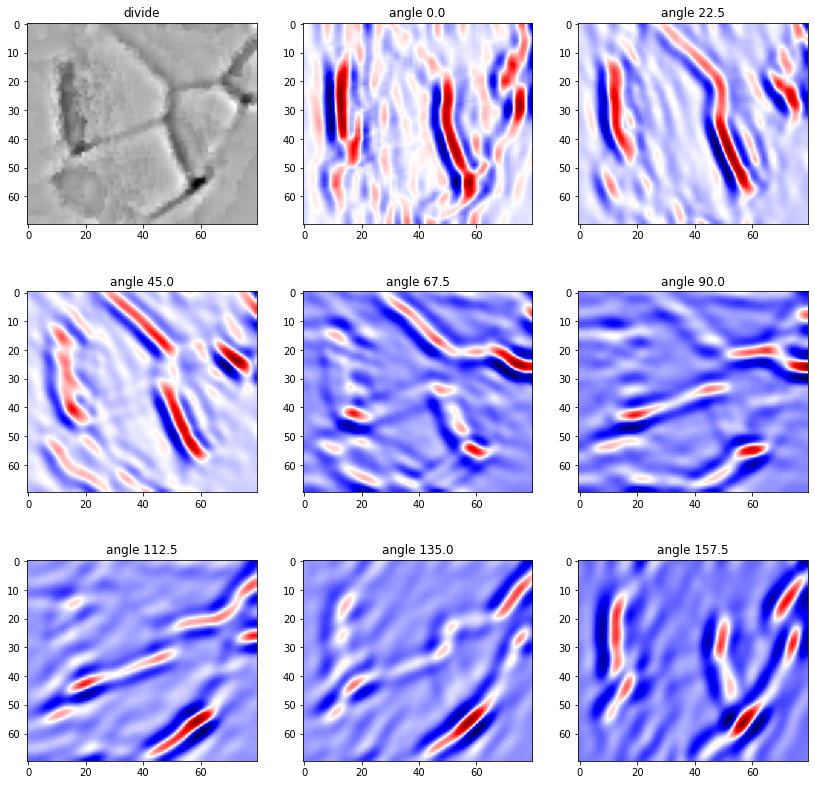

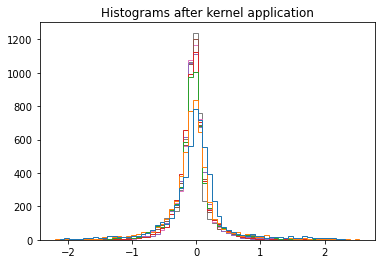

In [7]:
# application of the kernels at angles
k = np.array([[1, 1, 1, -1.75, -2.5, -1.75, 1, 1, 1]] *9) / 3

plt.figure(figsize=(14,14))
plt.subplot(3, 3, 1)
plt.imshow(divide, cmap='gray')
plt.title("divide")
    
res_hist = []
for a in range(0, 8):
    res = edges.convolve(divide, k)
    res_hist.append(res.ravel())
    
    plt.subplot(3, 3, a+2)
    plt.imshow(res, cmap='seismic')
    plt.title(f"angle {a *22.5}")
    
    k = rotate(k, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
    
plt.show()

plt.hist(res_hist, bins=64, label='res1', histtype='step')
plt.title("Histograms after kernel application")
plt.show()

Two of the next kernels are simply shifted left and right in effort to tr to gain more information for the surroundings. The fourth kernel is expected to detect smaller features. One more kernel type is applied that returns the average value of pixels in a circle around the center pixel.

## Feature and label extracting functions

In [8]:
def plot_gallery_from_df(df, h, w, n_col=3):
    """
    Helper function to plot a gallery of images from dataframe
    """
    n_row = int(np.ceil(df.shape[1] / n_col))
    plt.figure(figsize=(12, 12 * n_row / n_col))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.1)
    i = 0
    for col in df:
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(df[col].values.reshape((h, w)), cmap=plt.cm.seismic)
        plt.title(col, size=10)
        plt.xticks(())
        plt.yticks(())
        i += 1

In [9]:
def equalize_histogram(img):
    """
    Matches the histogram of image to reference image histogram
    
    img -  grayscale image expected, any type is OK
    
    returns - img with matched histogram, type float32
    """
    # sanity check
    if img.ndim != 2:
        raise ValueError("Grayscale images expected!")
    
    ref_histogram = io.imread(r"train_test_images\full_image.tif", as_gray=True)
    ref_histogram = img_as_float32(ref_histogram)
    
    img = img_as_float32(img)
    img = match_histograms(img, ref_histogram) # float 64
    
    return img_as_float32(img)

In [10]:
def augment_image(img):
    """
    yields augmented images by appling noise and/or smoothening
    Note: rotation is not applied in this function, it is applied later to reduce timely operations
    
    img -  grayscale image expected, any type is OK, output is float32
    
    returns - images are in the 0 to 1 range float32; and index of the augmentation
    """
    # sanity check
    if img.ndim != 2:
        raise ValueError("Grayscale images expected!")
        
    img = img_as_float32(img)

    aug_img = img.copy()
    yield aug_img, 1

    aug_img = random_noise(img, mode='gaussian', mean=0.1, var=0.002, seed=43, clip=False)
    yield aug_img, 2
    
    aug_img = cv2.GaussianBlur(img, (3,3), 10)
    aug_img = random_noise(aug_img, mode='gaussian', mean=0.0, var=0.001, seed=43, clip=False)
    yield aug_img, 3

Augmentation 1


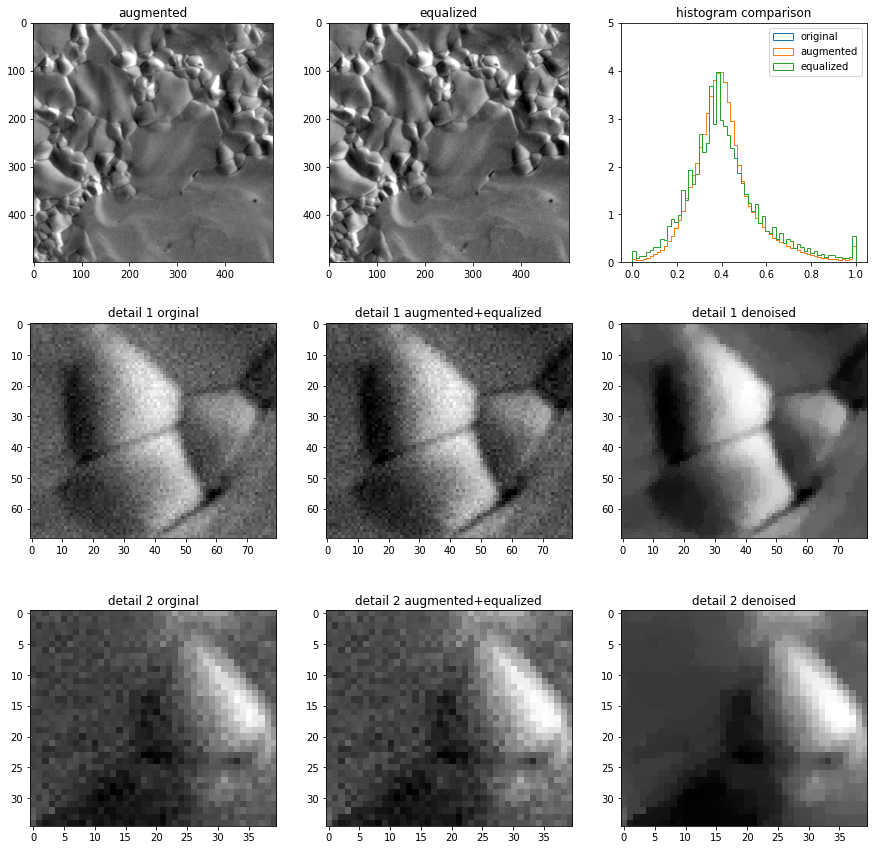

Augmentation 2


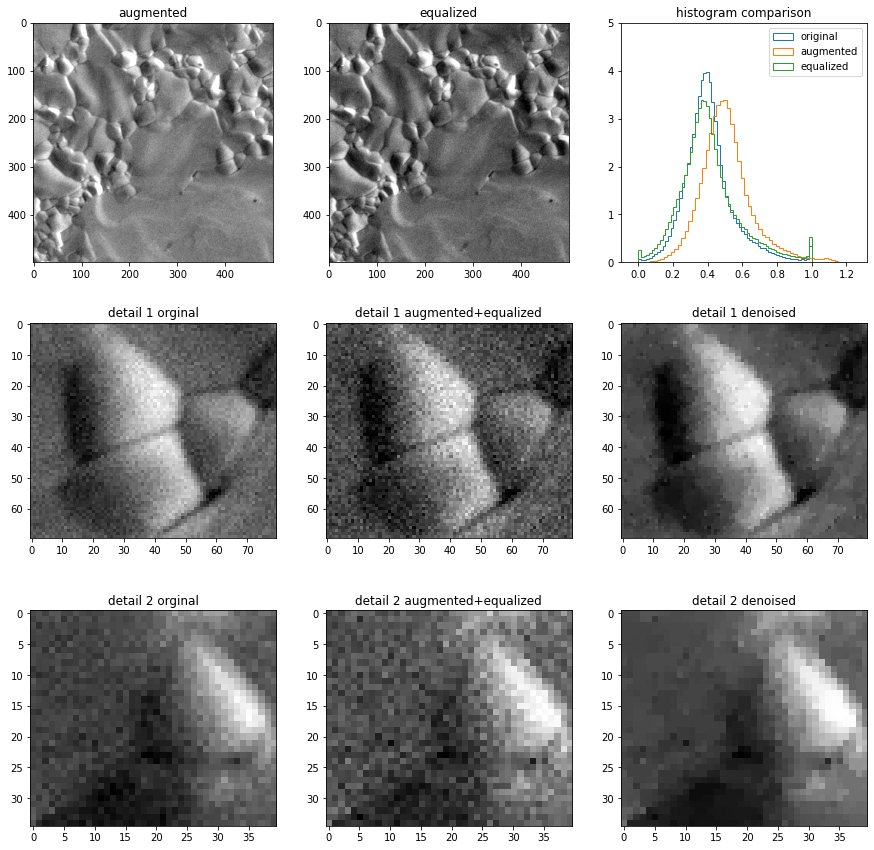

Augmentation 3


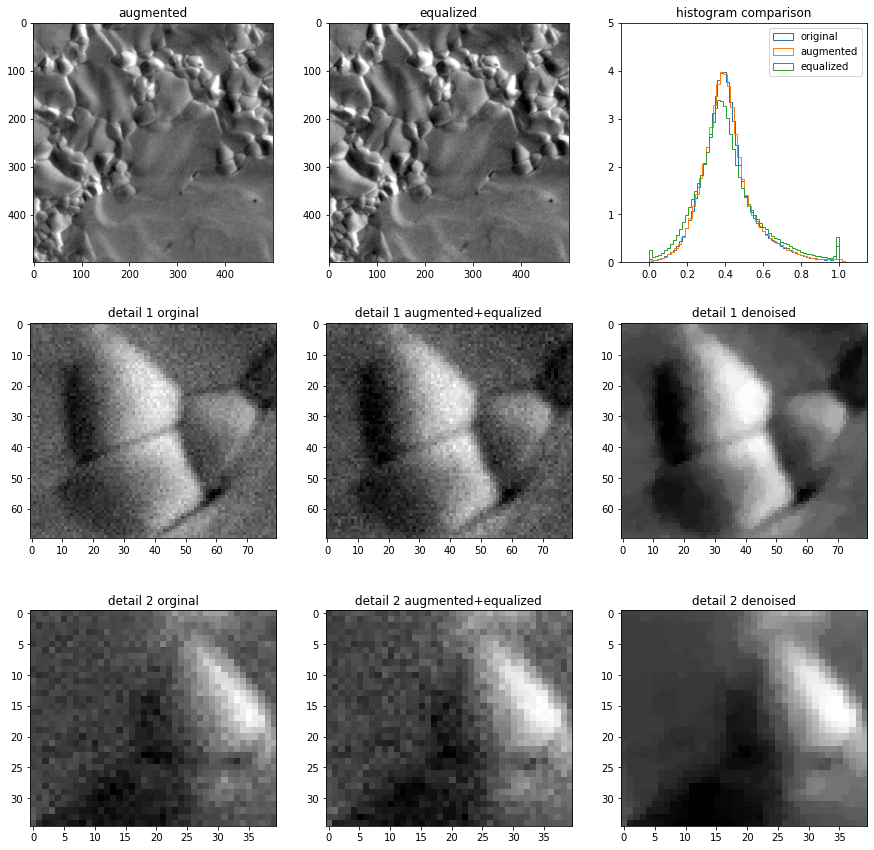

In [11]:
# unit test augment_image and preview
def preview_augment_image(test):
    """
    Show a preview of the applied augmentations
    """
    i = 0
    test = img_as_float32(test)
    for el, index in augment_image(test):
        assert(el.shape==test.shape)
        plt.figure(figsize=(15, 15))
        eq = equalize_histogram(el)
        den = denoise_tv_chambolle(eq, weight=0.03, eps=0.00000002, n_iter_max=2000) 
        
        print(f"Augmentation {index}")
        plt.subplot(3, 3, 1)
        plt.imshow(el, cmap="gray", vmin=0, vmax=1)
        plt.title(f"augmented")
        
        plt.subplot(3, 3, 2)
        plt.imshow(eq, cmap="gray", vmin=0, vmax=1)
        plt.title(f"equalized")
        
        plt.subplot(3, 3, 3)
        plt.hist(test.ravel(), bins=64, histtype="step", density=True, label='original')
        plt.hist(el.ravel(), bins=64, histtype="step", density=True, label='augmented')
        plt.hist(eq.ravel(), bins=64, histtype="step", density=True, label='equalized')
        plt.ylim(0, 5)
        plt.legend()
        plt.title(f"histogram comparison")
        
        plt.subplot(3, 3, 4)
        plt.imshow(test[250:320, 370:450], cmap="gray")
        plt.title(f"detail 1 orginal")
        plt.subplot(3, 3, 5)
        plt.imshow(eq[250:320, 370:450], cmap="gray")
        plt.title(f"detail 1 augmented+equalized")
        plt.subplot(3, 3, 6)
        plt.imshow(den[250:320, 370:450], cmap="gray")
        plt.title(f"detail 1 denoised")
        
        plt.subplot(3, 3, 7)
        plt.imshow(test[75:110, 390:430], cmap="gray")
        plt.title(f"detail 2 orginal")
        plt.subplot(3, 3, 8)
        plt.imshow(eq[75:110, 390:430], cmap="gray")
        plt.title(f"detail 2 augmented+equalized")
        plt.subplot(3, 3, 9)
        plt.imshow(den[75:110, 390:430], cmap="gray")
        plt.title(f"detail 2 denoised")
        
        # other patches [200:220, 150:210], [190:220, 250:300]
   
        plt.show()
        i += 2


preview_augment_image(io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:500, 0:500])

In [12]:
def circle_mask(r_inner, thickness):
    """
    Returns a kernel used for convolution operations
    r_inner, int - inner diameter with 0 
    thickness - the thickness of the periphery
    """
    res = disk(r_inner + thickness) - np.pad(disk(r_inner), thickness, mode='constant')
    return res / sum(res.ravel())


def get_filter_features(input_img, include_rotation=True, bg=True):
    """
    Extracts several features based on diffrent filters
    
    input_img -  expected float32 or float64 grayscale image
    include_rotation, bool - to make 4 rotations at 90deg or not
    bg, bool - to include background features or not
    
    returns a dataframe with length = number of pixels or number of pixels * 4 if rotations=True
    Every column is the intensity of the pixel after application of a filter
    """
    if input_img.ndim != 2:
        raise ValueError("Grayscale images expected!")
    if input_img.dtype != np.float64 and input_img.dtype != np.float32:
        # float16 is not working with open CV
        raise ValueError("Image must be float32 or float64!")
        
    # big advantage in speed; about 3 times faster to use float32 instead of 64
    if input_img.dtype == np.float64:
        input_img = img_as_float32(input_img)
        
    denoise = denoise_tv_chambolle(input_img, weight=0.03, eps=0.00000002, n_iter_max=2000)  
    gaussian = cv2.GaussianBlur(denoise, (9,9), 50) # not exported
    divide = cv2.divide(denoise, gaussian, scale=0.5) 
    sobel = filters.sobel(denoise) # not exported
    sqrt_sobel = np.sqrt(sobel)
    sobel_sq = np.sqrt(filters.sobel(sobel))
    sobel_h = filters.sobel_h(denoise)
    sobel_v = filters.sobel_v(denoise)
    sato = np.sqrt(filters.sato(divide, mode='constant'))
    laplace = filters.laplace(denoise)
    
    to_export = {'denoise' : denoise, 
                 'divide' : divide,
                 'sqrt_sobel' : sqrt_sobel,
                 'sobel_sq' : sobel_sq,
                 'sobel_h' : sobel_h,
                 'sobel_v' : sobel_v,
                 'sato' : sato,
                 'laplace' : laplace,
                }
    if bg:
        k = np.array([[1, 1, 1, -1.75, -2.5, -1.75, 1, 1, 1]] *9) / 3
        k_l = np.array([[1, -1.75, -2.5, -1.75, 1, 1, 1, 1, 1]] *9) / 3
        k_r = np.array([[1, 1, 1, 1, 1, -1.75, -2.5, -1.75, 1]] *9) / 3
        # k_f = np.array([[1, 1, -1.25, -1.5, -1.25, 1, 1]] *7) / 3
        k_ray = np.array([[0, 0, 0, 2, 3, 2, 0, 0, 0]] * 9) / 63


        for i in range(8):
            # appling the kenrnels at 8x22.5deg to obtain revolves
            to_export[f'rev_{i*22}'] = edges.convolve(divide, k)
            to_export[f'rev_l_{i*22}'] = edges.convolve(divide, k_l)
            to_export[f'rev_r_{i*22}'] = edges.convolve(divide, k_r)
            to_export[f'rev_ray_{i*22}'] = edges.convolve(divide, k_ray)
            # to_export[f'rev_f{i*22}'] = edges.convolve(divide, k_f)
            
            k = rotate(k, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
            k_l = rotate(k_l, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
            k_r = rotate(k_r, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
            k_ray = rotate(k_ray, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
            # k_f = rotate(k_f, 22.5, reshape=True, mode='grid-constant', prefilter=False, order=3)
            
#         k_1 = circle_mask(1, 1)
#         k_2 = circle_mask(2, 1)
#         k_3 = circle_mask(3, 2)
        k_4 = circle_mask(5, 3)
        
#         to_export['d_ring1'] = edges.convolve(denoise, k_1)
#         to_export['d_ring2'] = edges.convolve(denoise, k_2)
#         to_export['d_ring3'] = edges.convolve(denoise, k_3)
        to_export['d_ring4'] = edges.convolve(denoise, k_4)
        to_export['d_ringd_div_4'] = edges.convolve(divide, k_4) 
        
    df = pd.DataFrame()
    df_result = pd.DataFrame()
    nrot = 4 if include_rotation else 1
    for i in range(nrot):
        for name, pic in to_export.items():
            df[name] = pic.reshape(-1)
            if nrot - i >= 1:
                to_export[name] = np.rot90(pic)
        df_result = df_result.append(df, ignore_index=True)

    # reducing the used memory
    df_result = df_result.astype(np.float32)
    
    return df_result

In [13]:
# unit test get_filter_features and preview
img_test = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:560, 0:625]
img_test = img_as_float32(img_test)
fetaures_filters = get_filter_features(img_test, include_rotation=True, bg=False)
assert(fetaures_filters.shape == (560*625*4, 8))
start = time.time() 
fetaures_filters = get_filter_features(img_test, include_rotation=True, bg=True)
print(f"time needed {time.time() - start:.2f}s")
assert(fetaures_filters.shape == (560*625*4, 8+4*8+2))

# demostrating the filters
def preview_filter_features(img):
    """
    Demonstrates the filters (without the large kernel convolutions)
    """
    fetaures_filters = get_filter_features(img, include_rotation=False, bg=False)
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.1)
    i = 0
    print("Demonstrating the filters")
    for col in fetaures_filters:
        plt.subplot(3, 3, i + 1)
        plt.imshow(fetaures_filters[col].values.reshape(img.shape), cmap=plt.cm.gray)
        plt.title(col, size=10)
        plt.xticks(())
        plt.yticks(())
        i += 1
    plt.subplot(3, 3, i + 1)
    plt.hist(fetaures_filters, histtype='step', bins="fd", label=fetaures_filters.columns, density=True)
    plt.title("histograms")
    plt.legend()
    plt.show()
    
    
preview_filter_features(img_test)

time needed 7.22s
Demonstrating the filters


In [14]:
def get_all_data(input_imges, input_masks, include_rotation=True, bg=True):
    """
    combines the data from features and labels into one dataframe that will beused for ML.
    Adds information columns and performs augmentation.
    
    input_imges - list of images; must be grayscale, any type is OK
    input_masks - list of images; must be grayscale, any type is OK;
                  any non 0 value is considered as class 1 === grain border
    include_rotation - bool; whether or not to apply rotations
    bg - include background features or not
    
    returns a data frame with information, features and lables
    """
    # sanity checks
    if not isinstance(input_imges, list):
        raise ValueError("List of input_imges expected!")
    if not isinstance(input_masks, list):
        raise ValueError("List of input_masks expected!")
    if len(input_imges) != len(input_masks):
        raise ValueError("Number of images and masks must be equal!")
    for img, mask in zip(input_imges, input_masks):
        if img.ndim > 2 or mask.ndim > 2:
            raise ValueError("Grayscale images and masks expected!")
        if img.shape != mask.shape:
            raise ValueError("Images and coresponding masks must have the same shape")

    result = pd.DataFrame()
    for img, label_mask in zip(input_imges, input_masks):
        # preparation
        nrot = 4 if include_rotation else 1
        label_mask = label_mask.astype(bool).astype(np.uint8) # the labels should be 0 and 1 class  
        h, w = label_mask.shape
        pixel_nums = np.arange(0, h*w, dtype=np.uint32).reshape(h, w) # from 1 to the end
        
        # creating labels and information columns
        labels = []
        pixel_id = []
        rotations = []
        for i in range(nrot):
            label_mask_1d = label_mask.reshape(-1)
            labels.extend(label_mask_1d)
            pixel_nums_1d = pixel_nums.reshape(-1)
            pixel_id.extend(pixel_nums_1d)
            rotations.extend([i * 90] * len(pixel_nums_1d))
            label_mask = np.rot90(label_mask)
            pixel_nums = np.rot90(pixel_nums)
            
        labels = pd.Series(labels, dtype=np.uint32, name = 'pixel_class')
        pixel_id = pd.Series(pixel_id, dtype=np.uint32, name = 'pixel_id')
        rotations = pd.Series(rotations, dtype=np.uint32, name='rotation')
    
        # creating features
        for tuned_img, au_idx in augment_image(img):
            tuned_img = equalize_histogram(tuned_img)
            features = get_filter_features(tuned_img, include_rotation=include_rotation, bg=bg)
            aug = pd.Series([au_idx] * len(features), name = "augmentation", dtype=np.uint8)
            features = pd.concat([aug, rotations, pixel_id, features, labels], axis=1)
            result = pd.concat([result, features], axis=0, ignore_index=True)
    return result

In [15]:
# unit test get_all_data
img_1 = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:50, 0:50] 
mask_1 = io.imread(r"train_test_images\full_image_mask.tif", as_gray=True)[0:50, 0:50] 
fetaures_test = get_all_data([img_1], [mask_1], True, True)
assert(fetaures_test.shape == (50*50*3*4, 3 + (8+2+4*8) + 1))

## Creating features and labels dataframe

In [16]:
# extracting data
start = time.time()
img_1 = io.imread(r"train_test_images\full_image.tif", as_gray=True)
mask_1 = io.imread(r"train_test_images\full_image_mask.tif", as_gray=True)
all_data = get_all_data([img_1], [mask_1], True, bg=True)
print(time.time() - start)
size = sys.getsizeof(all_data) / 1024**3
print(f"all_data has size of {size} GB")

72.6197407245636
all_data has size of 2.312178745865822 GB


## Save/Load all features and lables

In [17]:
# all_data.to_hdf("2021-11-18 all_data.hdf", key="df")

In [18]:
# start = time.time()
# all_data = pd.read_hdf("2021-11-18 all_data.hdf")
# print(f"Reading from hard drive for {time.time() - start:.2f}s")

# EDA of the features

## Correlation of features

### between filters and label

In [19]:
cols_to_drop = ['augmentation', 'rotation', 'pixel_id']
np.random.seed(47)
short_df = all_data.drop(cols_to_drop, axis=1).sample(10_000) # taking random sample set to keep time reasanable
cor = short_df.corr()
plt.figure(figsize=(16,16))
sns.heatmap(cor, annot=False, cmap=plt.cm.twilight_shifted)
plt.title("corrleation between moving windows and filter features")
plt.show()

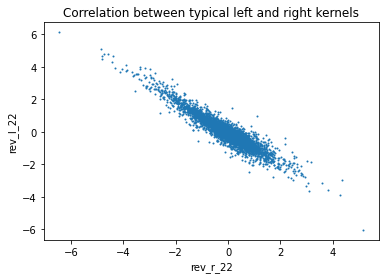

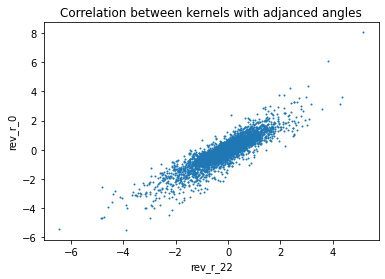

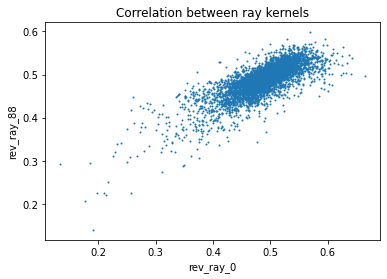

In [21]:
plt.title("Correlation between typical left and right kernels")
plt.scatter(short_df.rev_r_22, short_df.rev_l_22, s=1)
# plt.scatter(short_df[short_df.pixel_class==1].rev_r_22, short_df[short_df.pixel_class==1].rev_l_22, s=1)
plt.xlabel('rev_r_22')
plt.ylabel('rev_l_22')
plt.show()

plt.title("Correlation between kernels with adjanced angles")
plt.scatter(short_df.rev_r_22, short_df.rev_r_0, s=1)
plt.xlabel('rev_r_22')
plt.ylabel('rev_r_0')
plt.show()

plt.title("Correlation between ray kernels")
plt.scatter(short_df.rev_ray_0, short_df.rev_ray_88, s=1)
plt.xlabel('rev_ray_0')
plt.ylabel('rev_ray_88')
plt.show()

There are some features with high correlation. Some typical relations are demonstrated:
- between left and right kernels
- between adjacent angles
- between all ray kernels

The selected features will be used for further analysis. 

## variation of features

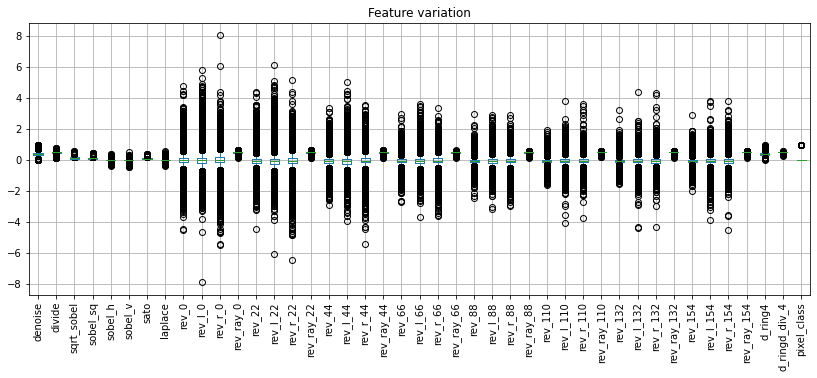

In [22]:
plt.figure(figsize=(14,5))
short_df.boxplot(rot=90)
plt.title("Feature variation")
plt.show()

In [23]:
short_df.drop("pixel_class", axis=1).hist(bins=64, grid=False, layout=(7, 7), figsize=(15,15))
plt.title("Distributions of features")
plt.show()

In [24]:
short_df.describe().T

count      mean       std       min       25%       50%  \
denoise        10000.0  0.409878  0.163234  0.006135  0.312768  0.386211   
divide         10000.0  0.493347  0.053534  0.121572  0.479992  0.498937   
sqrt_sobel     10000.0  0.155046  0.095898  0.002111  0.083672  0.136975   
sobel_sq       10000.0  0.117631  0.068900  0.002009  0.068401  0.101842   
sobel_h        10000.0 -0.000111  0.044394 -0.385581 -0.013922 -0.000160   
sobel_v        10000.0 -0.000275  0.058523 -0.428921 -0.010981  0.001034   
sato           10000.0  0.094237  0.056422  0.000000  0.053285  0.081684   
laplace        10000.0 -0.001220  0.055259 -0.357383 -0.018634 -0.000033   
rev_0          10000.0  0.004856  0.533450 -4.488935 -0.143003 -0.001040   
rev_l_0        10000.0  0.000606  0.660876 -7.902287 -0.199673 -0.014897   
rev_r_0        10000.0  0.001758  0.660583 -5.487210 -0.130384  0.012912   
rev_ray_0      10000.0  0.493405  0.036469  0.133540  0.485628  0.498893   
rev_22         10000.0 -0.038342  0.511761 -4.462803 -0.174042 -0.046383   
rev_l_22       10000.0 -0.043815  0.633585 -6.042306 -0.239526 -0.056483   
rev_r_22       10000.0 -0.038565  0.630656 -6.453489 -0.168327 -0.030411   
rev_ray_22     10000.0  0.493386  0.035982  0.112321  0.486685  0.498861   
rev_44         10000.0 -0.043952  0.410981 -2.901995 -0.158651 -0.047643   
rev_l_44       10000.0 -0.043479  0.546774 -3.924961 -0.224848 -0.055317   
rev_r_44       10000.0 -0.040844  0.541571 -5.433506 -0.156459 -0.032490   
rev_ray_44     10000.0  0.493530  0.033243  0.103787  0.486692  0.498691   
rev_66         10000.0 -0.049717  0.320696 -2.733212 -0.145496 -0.047590   
rev_l_66       10000.0 -0.041031  0.445426 -3.661679 -0.197089 -0.051557   
rev_r_66       10000.0 -0.043903  0.440572 -3.600402 -0.151108 -0.035253   
rev_ray_66     10000.0  0.493677  0.030357  0.114109  0.486783  0.498681   
rev_88         10000.0 -0.049525  0.263807 -2.428334 -0.133100 -0.049241   
rev_l_88       10000.0 -0.042650  0.363987 -3.151042 -0.167395 -0.047881   
rev_r_88       10000.0 -0.043326  0.362896 -2.944095 -0.149624 -0.040186   
rev_ray_88     10000.0  0.493722  0.028262  0.139615  0.486962  0.498702   
rev_110        10000.0 -0.047754  0.232619 -1.607340 -0.122414 -0.049265   
rev_l_110      10000.0 -0.043818  0.329763 -4.032151 -0.141863 -0.042093   
rev_r_110      10000.0 -0.041985  0.330070 -3.755179 -0.152243 -0.046090   
rev_ray_110    10000.0  0.493693  0.027255  0.166903  0.487495  0.498686   
rev_132        10000.0 -0.046072  0.232340 -1.519260 -0.119750 -0.048879   
rev_l_132      10000.0 -0.043873  0.346072 -4.379208 -0.135929 -0.038376   
rev_r_132      10000.0 -0.041249  0.348819 -4.297964 -0.159550 -0.050033   
rev_ray_132    10000.0  0.493615  0.027395  0.140138  0.487352  0.498771   
rev_154        10000.0 -0.045437  0.257359 -2.011122 -0.120294 -0.048435   
rev_l_154      10000.0 -0.042395  0.393840 -3.855934 -0.132955 -0.036606   
rev_r_154      10000.0 -0.041793  0.396376 -4.492362 -0.174917 -0.051424   
rev_ray_154    10000.0  0.493563  0.028359  0.159699  0.487490  0.498834   
d_ring4        10000.0  0.410583  0.125252  0.023144  0.335206  0.394672   
d_ringd_div_4  10000.0  0.493728  0.017843  0.285862  0.489021  0.498047   
pixel_class    10000.0  0.106800  0.308874  0.000000  0.000000  0.000000   

                    75%       max  
denoise        0.476471  0.991362  
divide         0.513995  0.774620  
sqrt_sobel     0.209996  0.605854  
sobel_sq       0.150162  0.478480  
sobel_h        0.011035  0.408795  
sobel_v        0.020105  0.518548  
sato           0.124809  0.385000  
laplace        0.016668  0.583508  
rev_0          0.134996  4.807233  
rev_l_0        0.132174  5.820693  
rev_r_0        0.201219  8.050320  
rev_ray_0      0.507124  0.664765  
rev_22         0.070280  4.391633  
rev_l_22       0.073850  6.130388  
rev_r_22       0.154774  5.167499  
rev_ray_22     0.506634  0.652241  
rev_44         0.062292  3.339938  
rev_l_44       0.066895 

Variation is reasanable. Scaling of data is not needed for the intended Xgboost model, see also https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost

Scaling was tried (not included) but no difference in results was observed. Scaling will not be used.

# Dividing the data into train and test

It is important to ensure that one pixel_id is either in train or test. 
Otherwise information may leak from test to train, especially if augmentation impose minimal modifications. Later group CV will be used to ensure different pixel_id are in train and validation sets.

p.s. On the other hand if the same pixel is in train and test with different augmentation it will test the robustness of the model when new data (with different brightness) is seen; the evaluation might be poor because this sample is already biased and might give too optimistic expectations.

In [25]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.30, n_splits=2, random_state = 7).split(all_data, groups=all_data['pixel_id']))

X_train = shuffle(all_data.iloc[train_inds], random_state=23)
info_train = X_train[["augmentation", "rotation", "pixel_id"]].copy()
X_train = X_train.drop(["augmentation", "rotation", "pixel_id"], axis=1)
y_train = X_train.pop("pixel_class")

X_test = shuffle(all_data.iloc[test_inds], random_state=27)
info_test = X_test[["augmentation", "rotation", "pixel_id"]].copy()
X_test = X_test.drop(["augmentation", "rotation", "pixel_id"], axis=1)
y_test = X_test.pop("pixel_class")

In [26]:
# unit chek
assert(len(y_train) + len(y_test) == len(all_data))
assert(len(X_train) + len(X_test) == len(all_data))

# large dataset is expected to be naturally stratied
s_train, s_test = np.sum(y_train) / len(y_train), np.sum(y_test) / len(y_test)
print(f"border pixels in train {s_train*100:.2f}%")
print(f"border pixels in test {s_test*100:.2f}%")

assert(abs(s_train-s_test)/s_train < 0.05) 

# checking every pixel_id is either in train or test
assert(len(set(info_train.pixel_id.unique()) & set(info_test.pixel_id.unique())) == 0)

border pixels in train 10.03%
border pixels in test 9.94%


In [27]:
# X_train.to_hdf("2021-11-18 X_train.hdf", 'df')
# info_train.to_hdf("2021-11-18 info_train.hdf", 'df')
# y_train.to_hdf("2021-11-18 y_train.hdf", 'df')
# X_test.to_hdf("2021-11-18 X_test.hdf", 'df')
# info_test.to_hdf("2021-11-18 info_test.hdf", 'df')
# y_test.to_hdf("2021-11-18 y_test.hdf", 'df')

In [28]:
# X_train = pd.read_hdf("2021-11-18 X_train.hdf")
# y_train = pd.read_hdf("2021-11-18 y_train.hdf")
# X_test = pd.read_hdf("2021-11-18 X_test.hdf")
# y_test = pd.read_hdf("2021-11-18 y_test.hdf")

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9601536, 42), (4114944, 42), (9601536,), (4114944,))

In [30]:
sys.getsizeof(X_train) / 1024**3, sys.getsizeof(X_test) / 1024**3

(1.573814406991005, 0.6744918972253799)

# Scoring metric

It is important to discuss how the model prediction will be used before defining best scoring metric. 

The plan to obtain grain statistics in production:
- take a production picture
- apply histogram matching
- extract features
- predict each pixel class (1 - boundary, 0 - not boundary)
- (optional) post-process/improve the prediction by applying filters
    - binary_closing to make boundaries more solid, and continues
    - remove islands of borders less than 5 pixels (removes random noise)
- apply flood fill on a distance map to find center of grains; this approach delivers seed points for the next step
- apply watershed to find the grain borders; this technique can close small interruptions in the grain boundaries
- performs statistics
    
The effect of wrong classification is:
- False positive: 
    - could be individual true pixels in middle of grains that will easily be removed if less than 5 pixels
    - larger clusters of pixels will not be removed,
        - if in close proximity to other true pixels <b>will create new, wrong  boundary</b>
        - if away from other true pixels will be neglected by the flood fill
- False negative 
    - if individual pixels are misclassified, will create a sparse border line. It will be repaired by the binary closing and/or the watershed algorithm
    - if medium sized clusters of pixels are misclassified, interruptions in the border could be created. Such interruptions will be repaired by the watershed algorithm
    - if large sized clusters of pixels are misclassified, the watershed will not be able to repair the boundary and <b>neighboring grains will be united</b>.

It is important whether the misclassified pixels are grouped or not. However we do not have that information as the validation and training sets are randomly selected. Another (better) possible approach is to divide the picture into patches for train/validate/test. Custom scoring metric can be created that applies similar post-processing and then evaluate the accuracy. Such custom scoring is outside the scope of this work. 

As both recall and precision are important, <b>f1 score</b> will be chosen for evaluation.
Wrong boundary creation is less problematic than missed boundary creation, so recall is more important than precision. The recall value will be monitored also.

# Feature selection and needed number of features

## Learning curves

In [31]:
def plot_performance_vs_sample_size(train_sizes=[0.1, 0.5, 0.75, 1], scoring='f1', model=None):
    """
    plots a learning curve for a model on X_train global varible.
    requires global variable X_train and y_train to be up to date
    train_sizes - amount of data for the learning_curve
    scoring - scoring metric
    model - classification model, if none, hard coded model will be used
    """
    if model == None:
        model = xgb.XGBClassifier(n_estimators = 50,
                          max_depth = 10,
                          scale_pos_weight = 2,
                          gamma=0, # default
                          eta=0.3, # default
                          random_state = 42,
                          n_jobs = -1,
                          eval_metric = 'logloss', # == default; silence a warning for change in versions
                          use_label_encoder = False,
                          importance_type = 'weight',
                          tree_method='gpu_hist', # use GPU
                          gpu_id=0, # use the first CUDA core
                          predictor = 'cpu_predictor', # decreases the GPU memory usage
                          # single_precision_histogram = True, #improves speed, but use only for small sets below 4e6 and double check
                         )
    gkf = GroupKFold(n_splits=5) # adding pixel grouping has neglicable effect
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        model,
        X_train,
        y_train,
        cv=gkf.split(X_train, y_train, groups=info_train.pixel_id),
        n_jobs=1, # one core is the fastest
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
#         shuffle=True, #alreaady shuffled with train_test_split
#         random_state=45,
        error_score='raise',
        verbose = 2,
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # f1 score
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(f"{scoring} score")
    axes[0].set_title(f"{scoring} score")
    
    # timing
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Time requirments")
    
    plt.show()
    return train_scores, test_scores

[learning_curve] Training set sizes: [  76812  768122 1920306 4608734]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .................................................... total time=   9.2s
[CV] END .................................................... total time=  12.3s
[CV] END .................................................... total time=  19.0s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   9.0s
[CV] END .................................................... total time=  12.3s
[CV] END .................................................... total time=  18.7s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   9.2s
[CV] END .................................................... total time=  12.7s
[CV] END .................................................... total time=  18.9s
[CV] END .................................................... total time=   5.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.4min finished


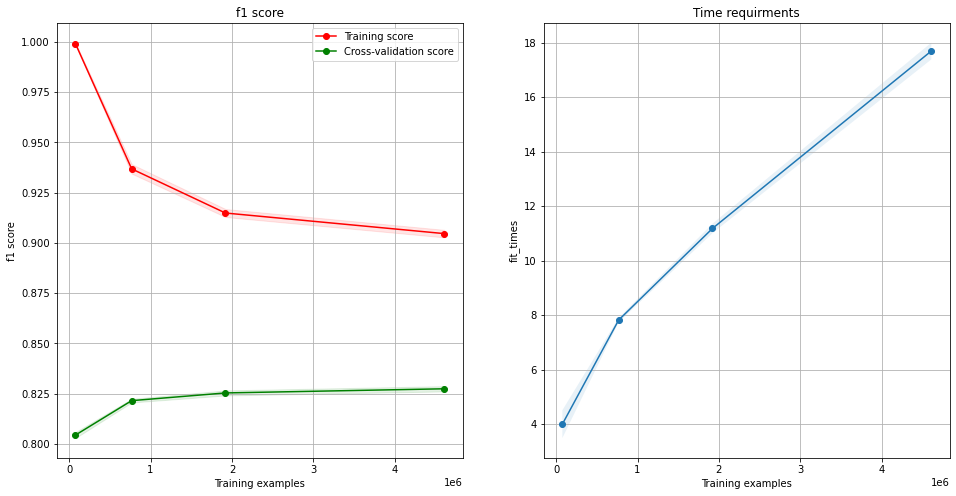

In [32]:
train_scores, test_scores = plot_performance_vs_sample_size([0.01, 0.1, 0.25, 0.6])

The graph indicate relatively high bias, because the f1 score is about 0.83. 
The over-fitting is moderate; above 2E+6 samples the gap between training and validation scores closes. The final slope of the validation curve is low, more data will have small benefit. The variation between the cross validations is low, (barely visible on the graph with shadows); it was expected due to the large and stratified datasets.

In [33]:
# Learning curve
def plot_learning_curve(model=None):
    """
    Plots a learning curves for hard coded model if not provided
    the logloss and classification error are analyzed as a function of the number of trees
    """
    if model == None:
        model = xgb.XGBClassifier(n_estimators = 50,
                              max_depth = 10,
                              scale_pos_weight = 2,
                              gamma=0, # default
                              eta=0.3, # default
                              random_state = 42,
                              n_jobs = -1,
                              # eval_metric = 'logloss', # == default; silence a warning for change in versions
                              use_label_encoder = False,
                              importance_type = 'weight',
                              tree_method='gpu_hist', # use GPU
                              gpu_id=0, # use the first CUDA core
                              predictor = 'cpu_predictor', # decreases the GPU memory usage
                              #  single_precision_histogram = True, #improves speed, but has problems with large datasets
                             )

    X_tr = X_train[:8_000_000]
    y_tr = y_train[:8_000_000]
    X_val = X_train[8_000_000:11_500_000] #30% for validation
    y_val = y_train[8_000_000:11_500_000]
    evalset = [(X_tr, y_tr), (X_val, y_val)]
    model.fit(X_tr, y_tr, eval_metric=["error", "logloss"], eval_set=evalset, verbose=False)
    
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    print(f'f1_score on validation set: {score}')
    
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    
    # plot learning curves
    plt.plot(x_axis, results['validation_0']['logloss'], label='train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='val')
    plt.title("XGBoost Log Loss")
    plt.xlabel("num of trees")
    plt.ylabel("logloss")
    plt.legend()
    plt.show()
    
    # plot classification error
    plt.plot(x_axis, results['validation_0']['error'], label='train')
    plt.plot(x_axis, results['validation_1']['error'], label='val')
    plt.title("XGBoost Classification Error")
    plt.xlabel("num of trees")
    plt.ylabel("Classification Error")
    plt.legend()
    plt.show()
    
    return results

f1_score on validation set: 0.8836442331138747


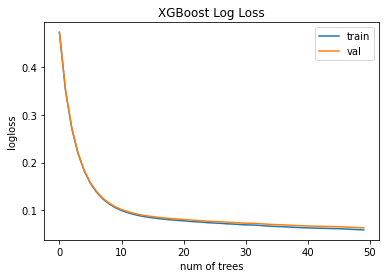

In [34]:
res = plot_learning_curve()

The final slope of the logloss is low, more trees might improve the model slightly. The big change in slope at about 10 trees suggest that the model learn mostly from the first 10 trees; learning might be a little too fast. More trees will improve mainly the train score with minimal improvement on the validation set, increasing the overfit.

## Feature importance

The feature importances can be used to select/modify the features for further iterations.

In [35]:
def plot_feature_importance(features, model=None):
    """
    returns the importances of the features in sorted order;
    if no model is provided a default model is constructed
    """
    if model == None:
        model = xgb.XGBClassifier(n_estimators = 50,
                          max_depth = 10,
                          scale_pos_weight = 2,
                          gamma=0, # default
                          eta=0.3, # default
                          random_state = 42,
                          n_jobs = -1,
                          eval_metric = 'logloss', # == default; silence a warning for change in versions
                          use_label_encoder = False,
                          importance_type = 'weight',
                          tree_method='gpu_hist', # use GPU
                          gpu_id=0, # use the first CUDA core
                          predictor = 'cpu_predictor', # decreases the GPU memory usage
                          #  single_precision_histogram = True, #improves speed
                         )

    model.fit(X_train[features][:2_500_000], y_train[:2_500_000])
    
    X_val = X_train[features][2_500_000:3_500_000]
    y_val = y_train[2_500_000:3_500_000]
    
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    print(f'f1_score: {score}')
    
    feature_imp = pd.Series(model.feature_importances_, index=features)
    feature_imp = feature_imp.sort_values(ascending = False)
    print("feature importances:")
    display(feature_imp)
    return feature_imp, score

In [36]:
# sequentially removing the least 5 important features and monitor the f1
score_list = list()
features_list = list()
features = list(X_train.columns)
while len(features) > 5:
    print(f"Number of features {len(features)}")
    features_list.append(features)
    imp, score = plot_feature_importance(features)
    score_list.append((len(features), score))
    features = imp.index[:-5]

Number of features 42
f1_score: 0.8707680535253549
feature importances:


d_ring4          0.056998
d_ringd_div_4    0.039424
sato             0.036563
rev_88           0.033268
sobel_h          0.032574
rev_132          0.032545
rev_110          0.031909
rev_0            0.031678
sobel_sq         0.031360
sobel_v          0.030175
sqrt_sobel       0.029395
denoise          0.029337
divide           0.027978
rev_66           0.027892
rev_154          0.027574
rev_22           0.026447
rev_44           0.022285
laplace          0.022198
rev_r_0          0.021331
rev_l_0          0.021071
rev_l_44         0.020406
rev_r_154        0.019654
rev_r_110        0.019510
rev_l_66         0.019163
rev_ray_110      0.019018
rev_l_110        0.018990
rev_r_66         0.018903
rev_r_132        0.018816
rev_r_88         0.018527
rev_l_88         0.017862
rev_l_132        0.017660
rev_ray_132      0.017400
rev_r_44         0.017371
rev_ray_66       0.017342
rev_l_154        0.016735
rev_l_22         0.016706
rev_r_22         0.016677
rev_ray_0        0.016128
rev_ray_88  

Number of features 37
f1_score: 0.8700015696739003
feature importances:


d_ring4          0.060732
d_ringd_div_4    0.044652
sato             0.037330
rev_88           0.035635
rev_0            0.035607
rev_132          0.034946
sobel_h          0.034429
rev_110          0.033826
sobel_sq         0.033252
denoise          0.033080
sobel_v          0.030323
rev_22           0.030151
divide           0.029864
sqrt_sobel       0.029777
rev_66           0.028973
rev_154          0.028916
rev_ray_66       0.027452
rev_44           0.026303
rev_ray_132      0.026102
rev_ray_110      0.025930
laplace          0.022915
rev_l_44         0.021508
rev_l_66         0.021335
rev_r_0          0.020704
rev_r_66         0.020560
rev_l_154        0.020330
rev_r_110        0.020101
rev_r_154        0.019899
rev_r_88         0.019268
rev_l_0          0.019210
rev_r_44         0.018923
rev_l_110        0.018780
rev_r_132        0.018378
rev_l_132        0.017889
rev_r_22         0.017775
rev_l_22         0.017746
rev_l_88         0.017401
dtype: float32

Number of features 32
f1_score: 0.8685883599544759
feature importances:


d_ring4          0.062575
d_ringd_div_4    0.046429
rev_0            0.039535
sato             0.039098
sobel_sq         0.037702
rev_88           0.037498
rev_132          0.036044
sobel_h          0.035927
rev_110          0.034211
sobel_v          0.032465
denoise          0.031855
rev_154          0.031505
rev_22           0.031331
rev_ray_132      0.031127
rev_66           0.031098
divide           0.030371
sqrt_sobel       0.030255
rev_ray_66       0.029440
rev_44           0.028829
rev_ray_110      0.027636
rev_l_44         0.027316
rev_r_0          0.026618
rev_l_110        0.025920
rev_r_154        0.025455
rev_l_154        0.024611
laplace          0.024436
rev_r_88         0.024233
rev_l_0          0.024029
rev_r_110        0.023942
rev_l_66         0.023447
rev_r_44         0.022982
rev_r_66         0.022080
dtype: float32

Number of features 27
f1_score: 0.8662888020909812
feature importances:


d_ring4          0.065445
d_ringd_div_4    0.049806
rev_l_44         0.046949
sato             0.042383
rev_r_88         0.041559
sobel_h          0.040469
rev_88           0.040381
rev_132          0.039998
rev_0            0.039585
rev_110          0.038584
sobel_sq         0.037789
rev_l_110        0.036552
sobel_v          0.035992
rev_r_0          0.035079
rev_22           0.034843
denoise          0.034608
rev_154          0.033223
rev_66           0.033164
sqrt_sobel       0.033106
divide           0.032899
rev_ray_66       0.032546
rev_r_154        0.031221
rev_44           0.030867
rev_ray_132      0.030808
rev_ray_110      0.028393
rev_l_154        0.027068
laplace          0.026685
dtype: float32

Number of features 22
f1_score: 0.8666722189289686
feature importances:


d_ring4          0.071583
d_ringd_div_4    0.058183
rev_ray_66       0.050488
rev_l_44         0.049999
sato             0.048183
rev_r_88         0.047347
rev_0            0.046137
rev_r_154        0.045791
rev_132          0.045705
sobel_h          0.045042
rev_88           0.045013
rev_22           0.044610
rev_66           0.043140
rev_r_0          0.042477
rev_110          0.042074
rev_l_110        0.041411
sobel_v          0.040201
denoise          0.040114
sobel_sq         0.039970
rev_154          0.039912
divide           0.037059
sqrt_sobel       0.035561
dtype: float32

Number of features 17
f1_score: 0.8613409123039647
feature importances:


d_ring4          0.098370
rev_ray_66       0.067183
d_ringd_div_4    0.066471
rev_0            0.061890
rev_132          0.061605
sobel_h          0.059614
rev_l_44         0.059187
rev_r_154        0.057081
rev_66           0.055175
sato             0.054805
rev_22           0.054719
sobel_v          0.052642
rev_r_88         0.052557
rev_110          0.051362
rev_l_110        0.049910
rev_r_0          0.049171
rev_88           0.048260
dtype: float32

Number of features 12
f1_score: 0.8433544612384203
feature importances:


d_ring4          0.122997
sobel_h          0.087407
rev_132          0.085148
rev_ray_66       0.084707
d_ringd_div_4    0.084062
rev_r_154        0.083358
rev_66           0.081392
rev_l_44         0.078282
rev_0            0.077490
sato             0.072678
sobel_v          0.071563
rev_22           0.070917
dtype: float32

Number of features 7
f1_score: 0.7574625073256026
feature importances:


d_ring4          0.175532
rev_r_154        0.150881
d_ringd_div_4    0.146794
sobel_h          0.140877
rev_ray_66       0.135875
rev_66           0.125413
rev_132          0.124628
dtype: float32

In [37]:
# plotting the f1 score by reducing the number of features
score_list = np.array(score_list)
plt.plot(score_list[:,0], score_list[:,1], 'o-')
plt.title("f1 sensitivity from number of features")
plt.xlabel("number of features")
plt.ylabel("f1 score")
plt.grid()
plt.show()

The data indicates a lot features can be removed without significant loss of f1 score. We can almost half the number of features with minimal penalty for f1. But some of these features are rotations of kernel filter, it is not logical to remove some of them as symmetry will be lost. The number of angles under consideration might be reduced (now they are 8x22.5deg). As the number of features is reasonable, all of them will be considered.

In [38]:
print("The following features could be used without significant decrease in f1")
print(*features_list[4], sep='\n')

The following features could be used without significant decrease in f1
d_ring4
d_ringd_div_4
rev_l_44
sato
rev_r_88
sobel_h
rev_88
rev_132
rev_0
rev_110
sobel_sq
rev_l_110
sobel_v
rev_r_0
rev_22
denoise
rev_154
rev_66
sqrt_sobel
divide
rev_ray_66
rev_r_154


# Grid search

## Grid search

In [39]:
# this cell takes too much time that is why it is commented; the results are presented below
# # grid search
# start = time.time()      
# sample_count = 3_750_000 # for test needed a couple of milions keep under3-4 or change single_precision_histogram=False
# gkf = GroupKFold(n_splits=3)
# X_gs = X_train[0:sample_count]
# y_gs = y_train[0:sample_count]
# cross_validation_splits = gkf.split(X_gs, y_gs, groups=info_train[0:sample_count].pixel_id)

# tuned_params = [{"eta" : [0.1, 0.2, 0.3],
#                  "gamma" : [0, 5],
#                  "scale_pos_weight" : [1, 1.5, 2, 3],
#                  "max_depth" : [6, 10],
#                  "n_estimators" : [50, 100, 150]
#                 }]

# clf2 = xgb.XGBClassifier(# n_estimators = 50,
# #                   max_depth = 10,
# #                   scale_pos_weight = 2,
# #                   gamma=0, # default
# #                   eta=0.3, # default
#                   random_state = 42,
#                   n_jobs = -1,
#                   eval_metric = 'logloss', # == default; silence a warning for change in versions
#                   use_label_encoder = False,
#                   importance_type = 'weight',
#                   tree_method='gpu_hist', # use GPU
#                   gpu_id=0, # use the first CUDA core
#                   predictor = 'cpu_predictor', # decreases the GPU memory usage
#                   # single_precision_histogram = True, #improves speed, but problems with large amount of data
#                  )
# grid_search = GridSearchCV(clf2, tuned_params, scoring=("f1", "recall"), refit="f1", cv=cross_validation_splits, verbose=2.5)
# grid_search.fit(X_gs, y_gs)
# xgb_classifier = grid_search.best_estimator_

# print(f"Using sample_count {sample_count}")
# print("XGB; best score:", grid_search.best_score_)
# print(grid_search.best_params_)
# fit_time = round(time.time() - start, 1)
# print(f"Gid search made for {fit_time}s")

In [40]:
# the cell above produced the following log on 18.11.2021
"""
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.800) recall: (test=0.747) total time=   6.3s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.748) total time=   6.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.750) total time=   6.2s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.797) total time=   6.2s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.798) total time=   6.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.800) total time=   6.2s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.805) recall: (test=0.829) total time=   6.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.803) recall: (test=0.828) total time=   6.5s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.805) recall: (test=0.831) total time=   6.4s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.792) recall: (test=0.865) total time=   6.6s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.791) recall: (test=0.867) total time=   6.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.792) recall: (test=0.869) total time=   6.4s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.811) recall: (test=0.766) total time=   9.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.768) total time=   9.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.771) total time=   9.4s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.818) recall: (test=0.811) total time=   9.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.812) total time=   9.3s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.814) total time=   9.3s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.814) recall: (test=0.838) total time=   9.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.812) recall: (test=0.837) total time=   9.9s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.814) recall: (test=0.840) total time=  10.0s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.802) recall: (test=0.871) total time=  10.2s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.801) recall: (test=0.872) total time=  10.1s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.801) recall: (test=0.874) total time=   9.9s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.817) recall: (test=0.775) total time=  13.1s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.818) recall: (test=0.776) total time=  13.3s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.818) recall: (test=0.779) total time=  13.1s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.816) total time=  13.2s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.817) total time=  13.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.819) total time=  13.1s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.818) recall: (test=0.840) total time=  13.3s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.817) recall: (test=0.841) total time=  13.5s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.818) recall: (test=0.844) total time=  13.2s
[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.806) recall: (test=0.873) total time=  13.1s
[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.806) recall: (test=0.874) total time=  13.1s
[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.806) recall: (test=0.876) total time=  13.1s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.776) total time=  15.3s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.777) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.780) total time=  15.3s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.815) total time=  15.5s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.814) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.818) total time=  15.3s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.838) total time=  15.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.821) recall: (test=0.838) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.823) recall: (test=0.842) total time=  15.5s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.868) total time=  15.5s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.868) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.814) recall: (test=0.871) total time=  15.7s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.825) recall: (test=0.785) total time=  25.7s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.825) recall: (test=0.785) total time=  24.8s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.789) total time=  25.2s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.819) total time=  25.7s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.828) recall: (test=0.819) total time=  25.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.821) total time=  25.1s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.840) total time=  25.6s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.827) recall: (test=0.839) total time=  25.0s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.843) total time=  25.8s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.821) recall: (test=0.865) total time=  25.8s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.821) recall: (test=0.868) total time=  25.1s

[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.821) recall: (test=0.868) total time=  25.7s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.789) total time=  34.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.789) total time=  33.4s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.829) recall: (test=0.793) total time=  33.7s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.832) recall: (test=0.820) total time=  34.3s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.818) total time=  34.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.832) recall: (test=0.822) total time=  34.0s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.839) total time=  34.8s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.838) total time=  34.2s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.831) recall: (test=0.842) total time=  34.4s
[CV 1/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.861) total time=  35.4s
[CV 2/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.864) total time=  34.0s
[CV 3/3] END eta=0.1, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.865) total time=  34.9s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.800) recall: (test=0.747) total time=   6.5s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.748) total time=   6.7s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.750) total time=   6.8s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.797) total time=   6.7s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.798) total time=   6.7s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.800) total time=   6.7s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.805) recall: (test=0.828) total time=   6.8s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.803) recall: (test=0.828) total time=   6.8s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.805) recall: (test=0.831) total time=   6.8s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.791) recall: (test=0.865) total time=   6.9s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.791) recall: (test=0.867) total time=   6.7s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.792) recall: (test=0.869) total time=   6.7s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.812) recall: (test=0.767) total time=  10.0s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.768) total time=  10.0s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.771) total time=  10.3s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.811) total time=  10.3s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.816) recall: (test=0.811) total time=  10.0s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.816) recall: (test=0.814) total time=  10.0s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.838) total time=  10.0s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.812) recall: (test=0.837) total time=  10.0s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.814) recall: (test=0.840) total time=  10.1s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.802) recall: (test=0.870) total time=   9.8s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.801) recall: (test=0.871) total time=  10.1s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.802) recall: (test=0.874) total time=  10.1s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.816) recall: (test=0.773) total time=  13.2s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.818) recall: (test=0.776) total time=  13.6s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.817) recall: (test=0.778) total time=  13.5s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.816) total time=  13.3s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.816) total time=  13.3s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.820) recall: (test=0.818) total time=  13.2s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.818) recall: (test=0.840) total time=  13.4s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.817) recall: (test=0.841) total time=  13.4s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.817) recall: (test=0.844) total time=  13.5s
[CV 1/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.807) recall: (test=0.872) total time=  13.4s
[CV 2/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.806) recall: (test=0.874) total time=  13.4s
[CV 3/3] END eta=0.1, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.806) recall: (test=0.877) total time=  13.4s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.776) total time=  14.8s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.778) total time=  14.8s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.781) total time=  14.9s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.815) total time=  15.1s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.815) total time=  15.1s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.818) total time=  15.1s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.838) total time=  15.3s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.839) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.823) recall: (test=0.842) total time=  15.3s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.814) recall: (test=0.868) total time=  15.6s

[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.814) recall: (test=0.868) total time=  15.4s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.870) total time=  15.5s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.786) total time=  23.3s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.825) recall: (test=0.786) total time=  23.2s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.790) total time=  23.6s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.819) total time=  24.0s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.819) total time=  23.7s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.822) total time=  23.8s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.840) total time=  24.6s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.827) recall: (test=0.840) total time=  24.0s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.844) total time=  24.1s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.822) recall: (test=0.866) total time=  24.7s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.821) recall: (test=0.866) total time=  24.0s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.820) recall: (test=0.868) total time=  24.6s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.789) total time=  30.2s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.789) total time=  30.1s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.792) total time=  30.0s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.832) recall: (test=0.820) total time=  31.0s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.818) total time=  30.8s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.832) recall: (test=0.823) total time=  31.4s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.831) recall: (test=0.838) total time=  32.3s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.839) total time=  31.7s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.842) total time=  31.7s
[CV 1/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.827) recall: (test=0.863) total time=  32.9s
[CV 2/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.864) total time=  32.6s
[CV 3/3] END eta=0.1, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.865) total time=  33.1s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.811) recall: (test=0.766) total time=   6.7s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.811) recall: (test=0.767) total time=   6.6s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.772) total time=   6.8s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.815) recall: (test=0.810) total time=   6.7s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.815) recall: (test=0.811) total time=   6.7s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.816) recall: (test=0.814) total time=   6.7s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.813) recall: (test=0.838) total time=   6.7s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.812) recall: (test=0.837) total time=   6.7s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.811) recall: (test=0.838) total time=   6.7s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.800) recall: (test=0.871) total time=   6.6s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.799) recall: (test=0.870) total time=   6.7s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.800) recall: (test=0.873) total time=   6.7s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.817) recall: (test=0.777) total time=  10.0s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.780) total time=  10.2s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.782) total time=  10.1s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.816) total time=   9.8s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.821) recall: (test=0.818) total time=   9.9s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.821) total time=  10.1s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.843) total time=   9.9s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.842) total time=   9.8s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.818) recall: (test=0.844) total time=   9.8s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.807) recall: (test=0.872) total time=   9.8s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.808) recall: (test=0.873) total time=   9.5s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.809) recall: (test=0.876) total time=   9.7s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.781) total time=  13.2s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.785) total time=  12.9s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.786) total time=  12.8s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.820) total time=  12.8s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.821) total time=  12.8s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.823) total time=  12.8s
[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.844) total time=  12.9s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.821) recall: (test=0.842) total time=  12.7s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.821) recall: (test=0.846) total time=  12.7s

[CV 1/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.812) recall: (test=0.873) total time=  13.3s
[CV 2/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.811) recall: (test=0.872) total time=  12.9s
[CV 3/3] END eta=0.2, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.877) total time=  12.9s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.785) total time=  14.3s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.785) total time=  14.1s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.787) total time=  14.1s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.817) total time=  14.2s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.816) total time=  14.3s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.822) total time=  14.6s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.826) recall: (test=0.838) total time=  14.5s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.838) total time=  14.0s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.840) total time=  14.1s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.819) recall: (test=0.864) total time=  14.6s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.819) recall: (test=0.865) total time=  14.1s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.818) recall: (test=0.865) total time=  14.4s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.789) total time=  23.1s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.790) total time=  23.1s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.793) total time=  23.0s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.831) recall: (test=0.819) total time=  23.2s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.816) total time=  23.4s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.831) recall: (test=0.820) total time=  23.6s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.831) recall: (test=0.835) total time=  24.1s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.834) total time=  23.5s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.836) total time=  23.8s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.857) total time=  24.2s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.856) total time=  23.7s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.859) total time=  24.4s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.829) recall: (test=0.792) total time=  32.0s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.829) recall: (test=0.792) total time=  31.6s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.830) recall: (test=0.796) total time=  32.0s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.833) recall: (test=0.816) total time=  32.6s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.831) recall: (test=0.815) total time=  32.9s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.832) recall: (test=0.819) total time=  32.4s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.830) total time=  33.3s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.831) total time=  33.1s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.833) total time=  33.0s
[CV 1/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.830) recall: (test=0.849) total time=  34.1s
[CV 2/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.830) recall: (test=0.849) total time=  34.0s
[CV 3/3] END eta=0.2, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.831) recall: (test=0.853) total time=  33.6s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.811) recall: (test=0.766) total time=   6.5s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.812) recall: (test=0.768) total time=   6.5s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.812) recall: (test=0.772) total time=   6.7s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.815) recall: (test=0.810) total time=   6.6s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.815) recall: (test=0.810) total time=   6.5s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.816) recall: (test=0.815) total time=   6.5s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.814) recall: (test=0.838) total time=   6.6s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.812) recall: (test=0.836) total time=   6.6s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.811) recall: (test=0.838) total time=   6.5s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.801) recall: (test=0.871) total time=   6.5s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.799) recall: (test=0.870) total time=   6.7s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.800) recall: (test=0.873) total time=   6.7s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.818) recall: (test=0.777) total time=  10.0s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.778) total time=  10.0s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.782) total time=   9.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.818) total time=   9.7s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.818) total time=   9.7s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.823) recall: (test=0.822) total time=   9.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.843) total time=   9.6s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.841) total time=   9.6s

[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.845) total time=   9.6s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.808) recall: (test=0.872) total time=   9.8s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.807) recall: (test=0.872) total time=   9.6s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.809) recall: (test=0.877) total time=   9.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.782) total time=  12.9s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.784) total time=  13.0s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.787) total time=  12.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.820) total time=  13.0s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.820) total time=  12.7s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.825) total time=  12.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.844) total time=  12.9s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.843) total time=  12.8s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.847) total time=  12.9s
[CV 1/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.811) recall: (test=0.872) total time=  13.0s
[CV 2/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.811) recall: (test=0.872) total time=  12.7s
[CV 3/3] END eta=0.2, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.812) recall: (test=0.876) total time=  12.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.783) total time=  13.3s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.784) total time=  13.2s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  13.2s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.816) total time=  13.6s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.818) total time=  13.3s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.820) total time=  13.5s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.837) total time=  13.7s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.839) total time=  13.6s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.841) total time=  13.6s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.820) recall: (test=0.864) total time=  14.1s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.818) recall: (test=0.865) total time=  13.7s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.818) recall: (test=0.868) total time=  13.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.788) total time=  18.3s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.788) total time=  18.1s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.792) total time=  17.8s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.818) total time=  20.8s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.818) total time=  19.6s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.821) total time=  21.1s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.835) total time=  21.6s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.834) total time=  21.8s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.837) total time=  21.6s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.858) total time=  22.2s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.857) total time=  22.0s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.826) recall: (test=0.860) total time=  22.3s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.788) total time=  19.5s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.826) recall: (test=0.788) total time=  19.3s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.792) total time=  19.1s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.818) total time=  22.2s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.818) total time=  20.9s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.831) recall: (test=0.821) total time=  23.1s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.834) total time=  24.0s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.834) total time=  23.1s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.831) recall: (test=0.837) total time=  24.3s
[CV 1/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.828) recall: (test=0.857) total time=  25.1s
[CV 2/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.828) recall: (test=0.854) total time=  26.2s
[CV 3/3] END eta=0.2, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.827) recall: (test=0.858) total time=  25.8s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.771) total time=   6.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.813) recall: (test=0.773) total time=   6.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.815) recall: (test=0.777) total time=   6.6s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.818) recall: (test=0.812) total time=   6.6s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.818) recall: (test=0.815) total time=   6.6s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.818) total time=   6.7s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.839) total time=   6.6s

[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.840) total time=   6.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.814) recall: (test=0.842) total time=   6.6s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.803) recall: (test=0.869) total time=   6.6s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.802) recall: (test=0.871) total time=   6.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.804) recall: (test=0.874) total time=   6.5s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.780) total time=   9.7s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.782) total time=   9.7s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.785) total time=   9.9s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.818) total time=  10.0s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.818) total time=   9.8s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.822) total time=   9.7s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.820) recall: (test=0.841) total time=   9.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.820) recall: (test=0.844) total time=   9.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.820) recall: (test=0.845) total time=   9.6s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.809) recall: (test=0.870) total time=   9.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.810) recall: (test=0.873) total time=   9.4s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.810) recall: (test=0.875) total time=   9.4s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.784) total time=  12.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.785) total time=  12.6s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.787) total time=  12.7s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.819) total time=  12.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.819) total time=  12.7s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.823) total time=  12.8s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.842) total time=  12.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.823) recall: (test=0.843) total time=  12.6s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.845) total time=  12.8s
[CV 1/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.869) total time=  13.0s
[CV 2/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.870) total time=  12.6s
[CV 3/3] END eta=0.3, gamma=0, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.874) total time=  13.0s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.787) total time=  13.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.786) total time=  13.7s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  13.6s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.815) total time=  13.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.815) total time=  13.8s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.818) total time=  14.0s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.834) total time=  13.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.824) recall: (test=0.833) total time=  13.7s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.826) recall: (test=0.838) total time=  14.0s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.821) recall: (test=0.857) total time=  14.4s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.820) recall: (test=0.860) total time=  13.9s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.820) recall: (test=0.860) total time=  14.1s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.791) total time=  22.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.825) recall: (test=0.790) total time=  22.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.827) recall: (test=0.794) total time=  22.9s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.813) total time=  23.5s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.812) total time=  23.0s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.815) total time=  22.8s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.829) recall: (test=0.827) total time=  23.4s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.828) total time=  23.0s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.832) total time=  23.1s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.827) recall: (test=0.846) total time=  23.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.827) recall: (test=0.847) total time=  23.8s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.827) recall: (test=0.850) total time=  23.8s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.793) total time=  32.2s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.794) total time=  31.8s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.828) recall: (test=0.796) total time=  32.1s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.831) recall: (test=0.811) total time=  32.8s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.829) recall: (test=0.809) total time=  32.7s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.830) recall: (test=0.814) total time=  32.4s

[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.823) total time=  32.9s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.830) recall: (test=0.822) total time=  32.5s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.832) recall: (test=0.828) total time=  32.7s
[CV 1/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.830) recall: (test=0.838) total time=  33.6s
[CV 2/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.830) recall: (test=0.838) total time=  33.6s
[CV 3/3] END eta=0.3, gamma=0, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.831) recall: (test=0.842) total time=  33.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.814) recall: (test=0.773) total time=   6.7s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.814) recall: (test=0.775) total time=   6.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.815) recall: (test=0.777) total time=   6.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.813) total time=   6.5s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.814) total time=   6.5s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.817) recall: (test=0.818) total time=   6.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.839) total time=   6.5s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.840) total time=   6.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.815) recall: (test=0.843) total time=   6.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.803) recall: (test=0.870) total time=   6.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.802) recall: (test=0.870) total time=   6.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=50, scale_pos_weight=3; f1: (test=0.803) recall: (test=0.873) total time=   6.4s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.818) recall: (test=0.780) total time=   9.8s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.819) recall: (test=0.782) total time=   9.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.786) total time=   9.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.816) total time=   9.8s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.822) recall: (test=0.819) total time=   9.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.823) recall: (test=0.824) total time=   9.7s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.820) recall: (test=0.841) total time=   9.8s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.820) recall: (test=0.842) total time=   9.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=2; f1: (test=0.819) recall: (test=0.845) total time=   9.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.810) recall: (test=0.871) total time=   9.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.810) recall: (test=0.873) total time=   9.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=100, scale_pos_weight=3; f1: (test=0.809) recall: (test=0.875) total time=   9.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.820) recall: (test=0.782) total time=  12.1s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.821) recall: (test=0.785) total time=  12.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.789) total time=  13.0s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.824) recall: (test=0.818) total time=  12.9s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.820) total time=  12.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.824) total time=  12.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.821) recall: (test=0.842) total time=  12.8s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.823) recall: (test=0.844) total time=  12.5s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=2; f1: (test=0.822) recall: (test=0.846) total time=  12.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.814) recall: (test=0.870) total time=  12.7s
[CV 2/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.813) recall: (test=0.872) total time=  12.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=6, n_estimators=150, scale_pos_weight=3; f1: (test=0.812) recall: (test=0.873) total time=  12.9s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.788) total time=  12.9s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.823) recall: (test=0.787) total time=  12.4s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1; f1: (test=0.822) recall: (test=0.788) total time=  12.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.815) total time=  12.9s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.815) total time=  12.7s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.825) recall: (test=0.818) total time=  13.1s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.834) total time=  13.0s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.823) recall: (test=0.834) total time=  13.0s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.837) total time=  13.3s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.819) recall: (test=0.857) total time=  13.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.819) recall: (test=0.858) total time=  13.1s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=50, scale_pos_weight=3; f1: (test=0.819) recall: (test=0.859) total time=  13.4s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  15.1s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  15.8s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.790) total time=  15.8s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.814) total time=  16.9s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.814) total time=  16.8s

[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.817) total time=  16.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.826) recall: (test=0.831) total time=  17.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.832) total time=  17.0s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.834) total time=  18.4s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.824) recall: (test=0.849) total time=  20.3s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.848) total time=  20.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=100, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.852) total time=  20.0s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  16.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.789) total time=  17.2s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1; f1: (test=0.824) recall: (test=0.790) total time=  17.1s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.814) total time=  18.5s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.827) recall: (test=0.814) total time=  18.1s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=1.5; f1: (test=0.826) recall: (test=0.817) total time=  17.5s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.826) recall: (test=0.831) total time=  18.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.825) recall: (test=0.832) total time=  18.6s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=2; f1: (test=0.828) recall: (test=0.834) total time=  19.6s
[CV 1/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.824) recall: (test=0.849) total time=  21.6s
[CV 2/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.848) total time=  21.8s
[CV 3/3] END eta=0.3, gamma=5, max_depth=10, n_estimators=150, scale_pos_weight=3; f1: (test=0.825) recall: (test=0.852) total time=  21.4s
Using sample_count 3750000
XGB; best score: 0.8321497732103841
{'eta': 0.2, 'gamma': 0, 'max_depth': 10, 'n_estimators': 150, 'scale_pos_weight': 1.5}
Gid search made for 6928.3s
"""

"\nFitting 3 folds for each of 144 candidates, totalling 432 fits\n[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.800) recall: (test=0.747) total time=   6.3s\n[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.748) total time=   6.2s\n[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1; f1: (test=0.801) recall: (test=0.750) total time=   6.2s\n[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.797) total time=   6.2s\n[CV 2/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.798) total time=   6.2s\n[CV 3/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=1.5; f1: (test=0.807) recall: (test=0.800) total time=   6.2s\n[CV 1/3] END eta=0.1, gamma=0, max_depth=6, n_estimators=50, scale_pos_weight=2; f1: (test=0.

In [41]:
# print(f"Using sample_count {sample_count}")
# print("XGB; best score:", grid_search.best_score_)
# print(grid_search.best_params_)

# output on 18.11.2021
# Using sample_count 3750000
# XGB; best score: 0.8321497732103841
# {'eta': 0.2, 'gamma': 0, 'max_depth': 10, 'n_estimators': 150, 'scale_pos_weight': 1.5}

In [42]:
# load \ save \ load the grid search summary
# grid_search_summary = pd.DataFrame(grid_search.cv_results_)
# grid_search_summary.to_csv("2021-11-18b grid_search_summary.csv")
# xgb_classifier.save_model("2021-11-18b grid_search_xgb_classifier.model")
grid_search_summary = pd.read_csv("2021-11-18b grid_search_summary.csv")
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.load_model("2021-11-18b grid_search_xgb_classifier.model")

In [43]:
cols_to_view = ['mean_fit_time',
               'param_eta', 'param_gamma', 'param_max_depth', 'param_scale_pos_weight', 'param_n_estimators', #"params", 
               'mean_test_f1', 'std_test_f1',
               'mean_test_recall', 'std_test_recall',
               ]
grid_search_summary = grid_search_summary.astype({'param_eta': 'float64',
                                                  'param_gamma': 'float64',
                                                  'param_max_depth': 'float64',
                                                  'param_scale_pos_weight': 'float64',
                                                  'param_n_estimators': 'float64',
                                                 })
grid_search_summary[cols_to_view].sort_values(by='mean_test_f1', ascending=False).head(10)

mean_fit_time  param_eta  param_gamma  param_max_depth  \
69       30.836102        0.2          0.0             10.0   
70       31.189193        0.2          0.0             10.0   
45       29.289360        0.1          5.0             10.0   
118      30.931484        0.3          0.0             10.0   
21       32.277602        0.1          0.0             10.0   
46       30.002386        0.1          5.0             10.0   
22       32.707934        0.1          0.0             10.0   
65       21.911245        0.2          0.0             10.0   
119      31.613462        0.3          0.0             10.0   
71       31.966750        0.2          0.0             10.0   

     param_scale_pos_weight  param_n_estimators  mean_test_f1  std_test_f1  \
69                      1.5               150.0      0.832150     0.000741   
70                      2.0               150.0      0.832057     0.000222   
45                      1.5               150.0      0.831383     0.000700   
118                     2.0               150.0      0.831383     0.000859   
21                      1.5               150.0      0.831195     0.000835   
46                      2.0               150.0      0.830763     0.000714   
22                      2.0               150.0      0.830630     0.000880   
65                      1.5               100.0      0.830337     0.000801   
119                     3.0               150.0      0.830323     0.000290   
71                      3.0               150.0      0.830225     0.000473   

     mean_test_recall  std_test_recall  
69           0.816779         0.001984  
70           0.831161         0.001353  
45           0.820333         0.001669  
118          0.823991         0.002637  
21           0.819939         0.001833  
46           0.839799         0.001804  
22           0.839472         0.001492  
65           0.818423         0.001750  
119          0.839206         0.001665  
71           0.850108         0.001872

In [44]:
plt.figure(figsize=(14,8))
cmap = {1 : "blue", 1.5:"green", 2:"red", 3:"orange"}
w = grid_search_summary.param_scale_pos_weight.values
c = [cmap[el] for el in w]
plt.scatter( grid_search_summary.mean_test_recall, grid_search_summary.mean_test_f1, color=c)
plt.xlabel("recall")
plt.ylabel("f1")
plt.title("f1 recall balance")
plt.grid()
plt.gca().set_aspect("equal")
plt.show()

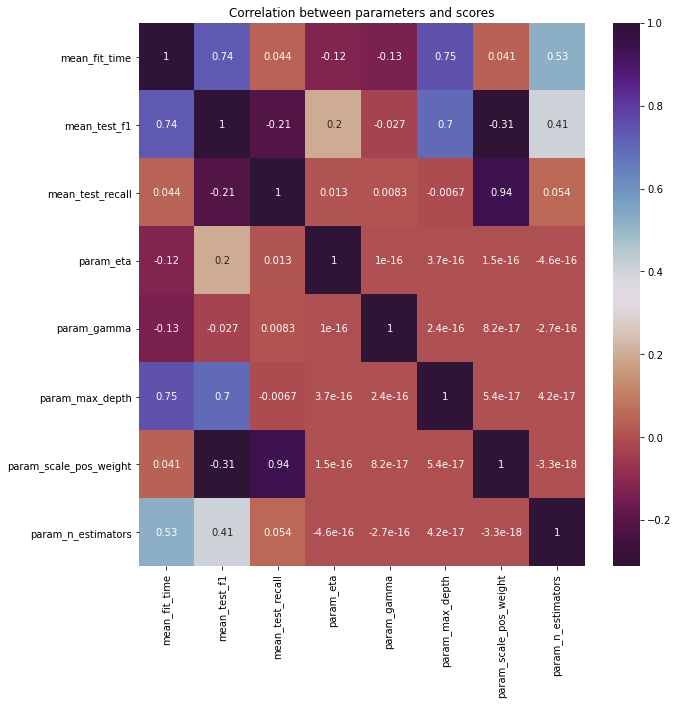

In [45]:
cor = grid_search_summary[['mean_fit_time', 'mean_test_f1', 'mean_test_recall', 'param_eta', 'param_gamma', 'param_max_depth', 'param_scale_pos_weight', 'param_n_estimators']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.twilight_shifted_r)
plt.title("Correlation between parameters and scores")
plt.show()

In [46]:
grid_search_summary[cols_to_view].sort_values(['param_scale_pos_weight', 'mean_test_f1'],ascending=False).\
                                 groupby('param_scale_pos_weight').head(1)

mean_fit_time  param_eta  param_gamma  param_max_depth  \
119      31.613462        0.3          0.0             10.0   
70       31.189193        0.2          0.0             10.0   
69       30.836102        0.2          0.0             10.0   
68       30.075568        0.2          0.0             10.0   

     param_scale_pos_weight  param_n_estimators  mean_test_f1  std_test_f1  \
119                     3.0               150.0      0.830323     0.000290   
70                      2.0               150.0      0.832057     0.000222   
69                      1.5               150.0      0.832150     0.000741   
68                      1.0               150.0      0.829112     0.000423   

     mean_test_recall  std_test_recall  
119          0.839206         0.001665  
70           0.831161         0.001353  
69           0.816779         0.001984  
68           0.793503         0.001875

The grid search found the best model as:
XGB; best score: 0.8321497732103841
{'eta': 0.2, 'gamma': 0, 'max_depth': 10, 'n_estimators': 150, 'scale_pos_weight': 1.5}

recall and scale_pos_weight are highly correlated. Further (small) score improvement could be achieved from fine tuning scale_pos_weight.

## Learning curve re-check

[learning_curve] Training set sizes: [  76812  768122 1920306 4608734]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   9.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] END .................................................... total time=  21.7s
[CV] END .................................................... total time=  29.8s
[CV] END .................................................... total time=  45.3s
[CV] END .................................................... total time=   9.5s
[CV] END .................................................... total time=  21.7s
[CV] END .................................................... total time=  30.1s
[CV] END .................................................... total time=  45.8s
[CV] END .................................................... total time=   9.4s
[CV] END .................................................... total time=  21.6s
[CV] END .................................................... total time=  29.9s
[CV] END .................................................... total time=  45.9s
[CV] END .................................................... total time=   9.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.8min finished


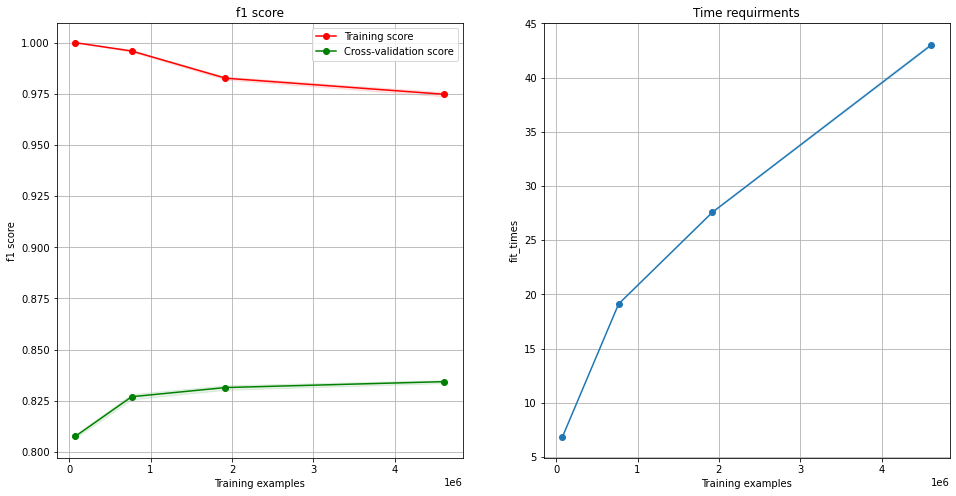

In [47]:
train_scores, test_scores = plot_performance_vs_sample_size([0.01, 0.1, 0.25, 0.6], model=xgb_classifier)

The accuracy benefit after 3e6 samples is low. The difference between training and CV score is relatively large - a sign for high variance/overfit. Removal of some features should be considered. It is important to note that the model run with (n_estimators = 50, max_depth = 10, scale_pos_weight = 2, gamma=0, eta=0.3) gave almost the same test score and lower trains score - less overfit. 
The following parameters are different and at least one of them is causing the overfit:
- n_estimators 50 changed to 150 (most probably)
- scale_pos_weight 2 changed to 1.5
- eta 0.3 changed to 0.2 ("Step size shrinkage used in update to prevents overfitting.")

Let's compare their grid search results:

In [48]:
print("The model from the prevois learning curve:")
display(grid_search_summary[cols_to_view][(grid_search_summary.param_n_estimators == 50) &
                                  (grid_search_summary.param_eta == 0.3) &
                                  (grid_search_summary.param_max_depth == 10) &
                                  (grid_search_summary.param_scale_pos_weight == 2) &
                                  (grid_search_summary.param_gamma == 0)
                                 ])
print("The model proposed from the grid search:")
display(grid_search_summary[cols_to_view][(grid_search_summary.param_n_estimators == 150) &
                                  (grid_search_summary.param_eta == 0.2) &
                                  (grid_search_summary.param_max_depth == 10) &
                                  (grid_search_summary.param_scale_pos_weight == 1.5) &
                                  (grid_search_summary.param_gamma == 0)
                                 ])

The model from the prevois learning curve:


mean_fit_time  param_eta  param_gamma  param_max_depth  \
110      12.582181        0.3          0.0             10.0   

     param_scale_pos_weight  param_n_estimators  mean_test_f1  std_test_f1  \
110                     2.0                50.0      0.825018     0.000866   

     mean_test_recall  std_test_recall  
110          0.835242         0.002284

The model proposed from the grid search:


mean_fit_time  param_eta  param_gamma  param_max_depth  \
69      30.836102        0.2          0.0             10.0   

    param_scale_pos_weight  param_n_estimators  mean_test_f1  std_test_f1  \
69                     1.5               150.0       0.83215     0.000741   

    mean_test_recall  std_test_recall  
69          0.816779         0.001984

The classification error will be checked as a function of the number of trees. The max number of trees will be as high as 300 in effort to try to find the overfitting point.

f1_score on validation set: 0.9705576180203682


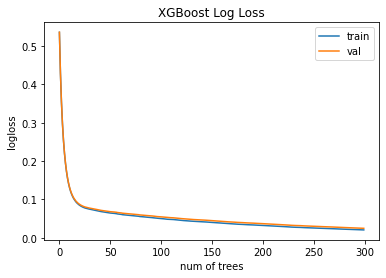

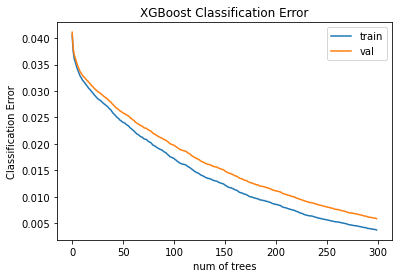

In [49]:
# the best model according grid search, but with 300 estimators
model_gs_300 = xgb.XGBClassifier(n_estimators = 300,
                          max_depth = 10,
                          scale_pos_weight = 1.5,
                          gamma=0, # default
                          eta=0.2, # default
                          random_state = 42,
                          n_jobs = -1,
                          eval_metric = 'logloss', # == default; silence a warning for change in versions
                          use_label_encoder = False,
                          importance_type = 'weight',
                          tree_method='gpu_hist', # use GPU
                          gpu_id=0, # use the first CUDA core
                          predictor = 'cpu_predictor', # decreases the GPU memory usage
                          #  single_precision_histogram = True, #improves speed, but has problems with large datasets
                         )


res_300 = plot_learning_curve(model_gs_300)

The model with 300 estimators has high ovefitting. The validation score improvement is lagging behind.

Comparison between both models (110 vs 69 from the grid search dataframe).
- f1 scores very similar, small advantage for 69
- recall scores better for 110
- fit time much lower for 110 
- 110 much more prone to overfitting

For further analysis the model proposed from learning (69) curve will be used:
(n_estimators = 50, max_depth = 10, scale_pos_weight = 2, gamma=0, eta=0.3)

# Model validation and improvement opportunities

## Building and trainning the selected model

The learning curve suggest more data is benefitial for the model performance. The selected model will be fit with all available trainning data.

In [50]:
def make_train_model():
    """
    This function return the selected model for production
    """
    model = xgb.XGBClassifier(n_estimators = 50, 
                      max_depth = 10,
                      scale_pos_weight = 2,
                      gamma=0,
                      eta=0.3,
                      random_state = 42,
                      n_jobs = -1,
                      eval_metric = 'logloss', # == default; silence a warning for change in versions
                      use_label_encoder = False,
                      importance_type = 'weight',
                      tree_method='gpu_hist', # use GPU
                      gpu_id=0, # use the first CUDA core
                      predictor = 'cpu_predictor', # decreases the GPU memory usage
                     )

    start = time.time()  
    model.fit(X_train, y_train)
    fit_time = round(time.time() - start, 1)
    print(f"Model fitted for {fit_time}s")
    
    y_pred = model.predict(X_train)
    print("Train scores:")
    print(f"    f1 score        : {f1_score(y_train, y_pred):.2f}")
    print(f"    precision score : {precision_score(y_train, y_pred):.2f}")
    print(f"    recall score    : {recall_score(y_train, y_pred):.2f}")
    
#     feature_imp = pd.Series(model.feature_importances_, index=X_train.columns)
#     feature_imp = feature_imp.sort_values(ascending = False)
#     display(feature_imp.head(10))

    return model

In [51]:
model = make_train_model()

Model fitted for 30.2s
Train scores:
    f1 score        : 0.89
    precision score : 0.87
    recall score    : 0.91


## Verification

### verification on all test data

In [52]:
y_pred = model.predict(X_test)
print("Verification scores:")
print(f"    f1 score        : {f1_score(y_test, y_pred):.2f}")
print(f"    precision score : {precision_score(y_test, y_pred):.2f}")
print(f"    recall score    : {recall_score(y_test, y_pred):.2f}")

Verification scores:
    f1 score        : 0.83
    precision score : 0.81
    recall score    : 0.84


The scores are similar to the best performers from the grid search.

### verification based on augmentation

In [53]:
for augmentation_id in np.sort(info_test.augmentation.unique()):
    X_aug = X_test[info_test.augmentation.values == augmentation_id]
    y_aug = y_test[X_aug.index]
    y_pred = model.predict(X_aug)
    print("Verification scores by augmentation:")
    print(f"    f1 score        : {f1_score(y_aug, y_pred):.2f}")
    print(f"    precision score : {precision_score(y_aug, y_pred):.2f}")
    print(f"    recall score    : {recall_score(y_aug, y_pred):.2f}")

Verification scores by augmentation:
    f1 score        : 0.85
    precision score : 0.83
    recall score    : 0.87
Verification scores by augmentation:
    f1 score        : 0.81
    precision score : 0.78
    recall score    : 0.85
Verification scores by augmentation:
    f1 score        : 0.81
    precision score : 0.83
    recall score    : 0.80


Augmentation 2 and 3 are harder to predicted. They have aditional noise and gaussian smooth. Augmentation 1 is the original image, with no modifications.

### verification based on rotation

In [54]:
for rot in np.sort(info_test.rotation.unique()):
    X_rot = X_test[info_test.rotation.values == rot]
    y_rot = y_test[X_rot.index]
    y_pred = model.predict(X_rot)
    print(f"Verification scores by rotation {rot}:")
    print(f"    f1 score        : {f1_score(y_rot, y_pred):.3f}")
    print(f"    precision score : {precision_score(y_rot, y_pred):.3f}")
    print(f"    recall score    : {recall_score(y_rot, y_pred):.3f}")

Verification scores by rotation 0:
    f1 score        : 0.826
    precision score : 0.810
    recall score    : 0.842
Verification scores by rotation 90:
    f1 score        : 0.826
    precision score : 0.810
    recall score    : 0.842
Verification scores by rotation 180:
    f1 score        : 0.826
    precision score : 0.810
    recall score    : 0.842
Verification scores by rotation 270:
    f1 score        : 0.826
    precision score : 0.810
    recall score    : 0.842


Performance is the same among the four rotations. No bias is seen.

## Visual evaluation

The visual evalaution will provide more-real world performance, though without metrics. This evaluation includes all train and test data, and it would be (a little) better than real world conditions. This approach enables us to see systematic weaknesses in the feature selection.

In [55]:
def visual_eval(model=model, show=True, test_img=None, mask_expected=None):
    """
    provides visual evaluation for the performance of the model
    if no image or mask is provided, it will use hard coded picture.
    """
    if test_img == None or mask_expected == None:
        test_img = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:500, 0:500]
        mask_expected = io.imread(r"train_test_images\full_image_mask.tif", as_gray=True)[0:500, 0:500]
    mask_expected = mask_expected.astype(bool)
    test_img = img_as_float32(test_img)
    test_img = equalize_histogram(test_img)
    h, w = test_img.shape

    features = get_filter_features(test_img, include_rotation=False, bg=True)
    mask_predicted = model.predict(features).reshape(h, w)
    mask_predicted = mask_predicted.astype(bool)
    
#     test_img = denoise_tv_chambolle(test_img, weight=0.03, eps=0.00000002, n_iter_max=2000)  #optional
    img_review = color.gray2rgb(test_img)
    img_review[mask_expected & mask_predicted] = (0, 1, 0)
    img_review[mask_expected & ~mask_predicted] = (1, 0, 1) # fn, low recall score
    img_review[~mask_expected & mask_predicted] = (1, 0, 0) # fp, low precision score
    
    if show:
        plt.figure(figsize=(12,12))
        plt.imshow(img_review)
        plt.title("Mark-up picture")
        plt.show()
    return img_review

In [56]:
preview = visual_eval(show=False)

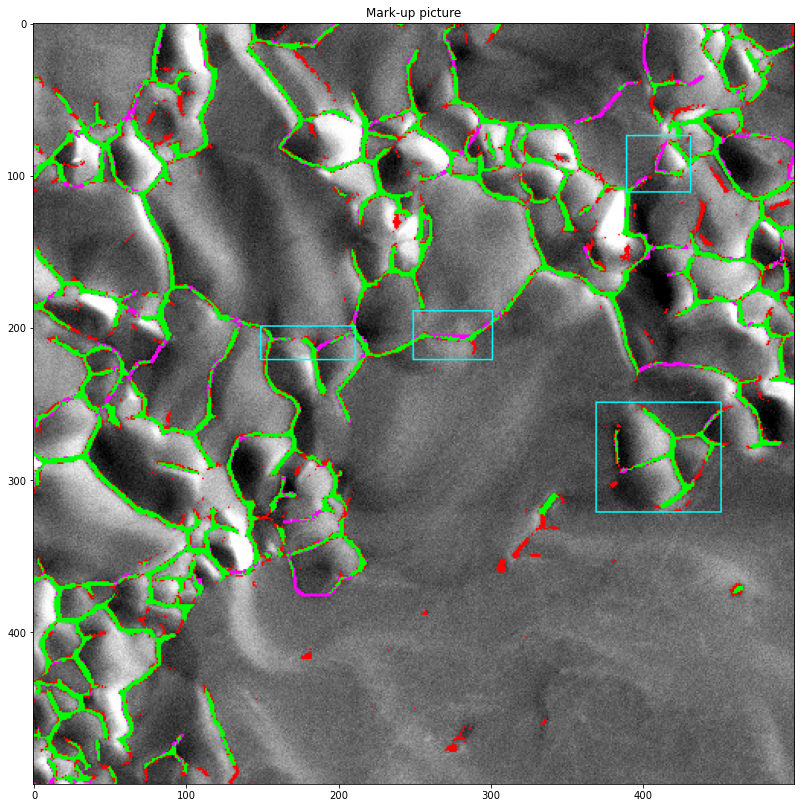

Legend: green - TP; pink - FN; red - FP;


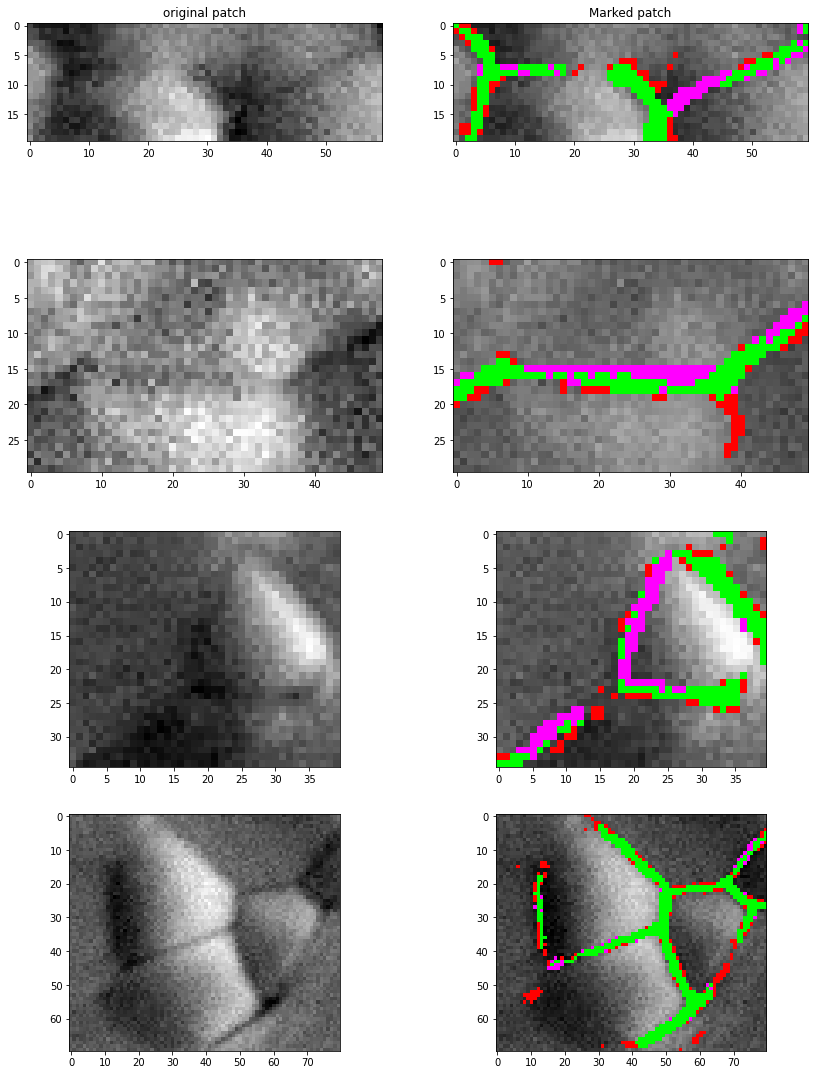

In [57]:
# Adding some zooms and preview
test_img = io.imread(r"train_test_images\full_image.tif", as_gray=True)[0:500, 0:500]

preview[draw.rectangle_perimeter((200,150), (220,210))] = (0, 1, 1)
preview[draw.rectangle_perimeter((190,250), (220,300))] = (0, 1, 1)
preview[draw.rectangle_perimeter((75,390), (110,430))] = (0, 1, 1)
preview[draw.rectangle_perimeter((250,370), (320,450))] = (0, 1, 1)

plt.figure(figsize=(14,14))
plt.imshow(preview)
plt.title("Mark-up picture")
plt.show()
print("Legend: green - TP; pink - FN; red - FP;")

plt.figure(figsize=(14,20))
plt.subplot(4, 2, 1)
plt.title("original patch")
plt.imshow(test_img[200:220, 150:210], cmap="gray")
plt.subplot(4, 2, 2)
plt.title("Marked patch")
plt.imshow(preview[200:220, 150:210], cmap="gray")

plt.subplot(4, 2, 3)
plt.imshow(test_img[190:220, 250:300], cmap="gray")
plt.subplot(4, 2, 4)
plt.imshow(preview[190:220, 250:300], cmap="gray")

plt.subplot(4, 2, 5)
plt.imshow(test_img[75:110, 390:430], cmap="gray")
plt.subplot(4, 2, 6)
plt.imshow(preview[75:110, 390:430], cmap="gray")

plt.subplot(4, 2, 7)
plt.imshow(test_img[250:320, 370:450], cmap="gray")
plt.subplot(4, 2, 8)
plt.imshow(preview[250:320, 370:450], cmap="gray")
plt.show()

The misclassified areas are hard to predict; even people could argue on some point. Some of the false model predictions are actually more accurate for the author. The results are accepted as good, if not excellent.

## Improvement opportunities

The following steps could be made to improve the model (in rpoduction):
- train on more pictures (this model is trainned only one picture)
- apply more augmentations
- feature selection; try with different features.
- train on different zoom level pictures (apply image pyramids)


# PRODUCTION

## Create, train, save/load production model

In [58]:
# create and train model
model = make_train_model()

Model fitted for 29.7s
Train scores:
    f1 score        : 0.89
    precision score : 0.87
    recall score    : 0.91


In [59]:
# save
# model.save_model("2021-11-18 model_production.model")

# load
# model = xgb.XGBClassifier()
# model.load_model("2021-11-18 model_production.model")

## Feature extraction and grain boundaries detection

In [60]:
def get_grain_borders(img, improve=False, plot=True, model=model):
    """
    adds a color traces to the detected grain boundarues
    img - iamge to analyze, grayscale floatexpected
    improve, bool - to apply binary operations to imrpove the mask of boundaries
    plot, bool - preview the results
    model - the ML model to use
    returns a colored image and a mask
    """
    if img.ndim != 2:
        raise ValueError("Grayscale image expected")
    if img.dtype != np.float64 and img.dtype != np.float32:
        raise ValueError("Image must be float32 or float64!")

    if img.dtype == np.float64:
        img = img_as_float32(img)
    
    img = equalize_histogram(img)
    features = get_filter_features(img, include_rotation=False, bg=True)
    column_names = features.columns
  
    h, w = img.shape

    predicted = model.predict(features)
    predicted = predicted.astype(bool) 
    mask_predicted = predicted.reshape((h, w))
    if improve:
        kernel = np.ones((3,3))
        mask_predicted = binary_closing(mask_predicted, kernel) # make boundaries more solid
        labeled_mask, _ = ndimage.label(mask_predicted, structure=kernel)
        regions = measure.regionprops(labeled_mask)
        for prop in regions:
            if prop.area <= 5:
                # remove small island of border pixels
                mask_predicted[labeled_mask == prop.label] = False 
    
    color_traces = np.zeros((h, w, 3), dtype=np.float32)
    color_traces[mask_predicted] = (1, 0, 0)
    marked = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.8, color_traces, 0.2, 0) # TODO this creates values larger than 1 improve
    
    if plot:
        plt.figure(figsize=(14, int(14*h/w)))
        plt.imshow(marked)
        plt.title("predicted grain boundaries")
        plt.show()
        
    return marked, mask_predicted

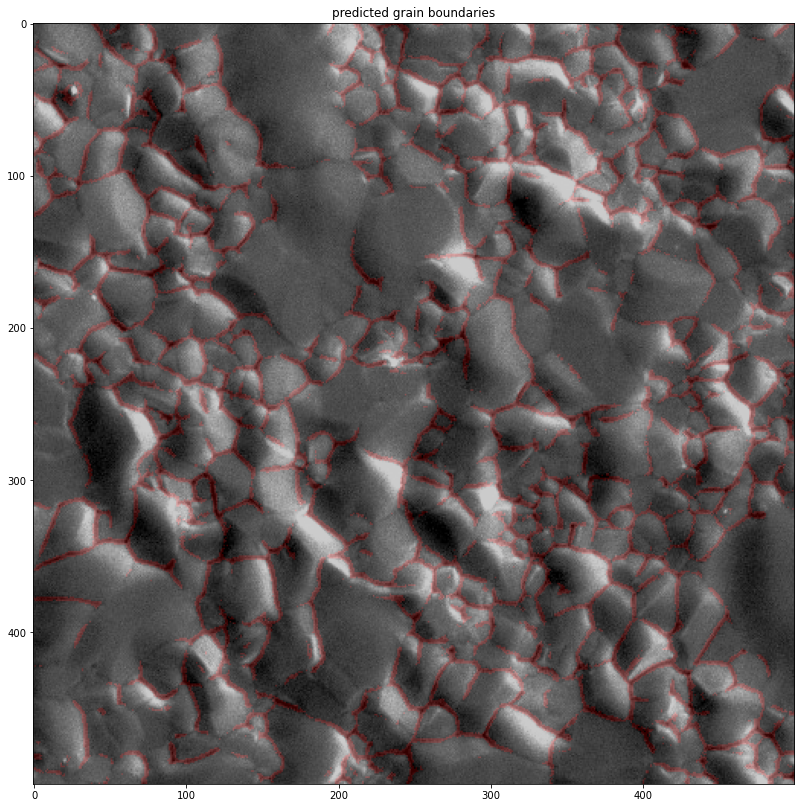

In [61]:
# test the approach on new pic, taken another day with diffrent settings
new_img = io.imread(r"production\production_1.tif", as_gray=True)[0:500, 0:500]
new_img = img_as_float32(new_img)
marked, mask_predicted = get_grain_borders(new_img)

## Grain detection with Watershed

In [62]:
def get_grains(img, mask_boundaries):
    """
    Shows:
        - a preview for the detected grains
        - Histogram and ECDF of the detected grains
    img - input image, grayscale
    mask_boundaries - mask for the boundaries
    """
    if img.ndim != 2:
        raise ValueError("Grayscale image expected")
    if img.dtype != np.float64 and img.dtype != np.float32:
        raise ValueError("Image must be float32 or float64!")

    if img.dtype == np.float64:
        img = img_as_float32(img)

    # obtainning distance map and peask
    mask_grains = ~mask_boundaries
    distance_map = ndimage.distance_transform_edt(mask_grains)
    peak_idx = peak_local_max(distance_map, min_distance=5, exclude_border=True)

    # filter unique peaks ony, that are not connected to other peaks
    dmap = distance_map.copy() # dmap will be modified by flood fill
    unique_idx = []
    for peak in peak_idx: # start from biggest peaks to the smallest
        max_dist = dmap[peak[0], peak[1]] # the value of the peak at x, y
        if max_dist > 0:
            # this peak has not been eaten so far
            unique_idx.append(peak)
            dmap = flood_fill(dmap, (peak[0], peak[1]), new_value=0, tolerance=0.6*max_dist) #tolerance=0.3*max_dist
    unique_idx = np.array(unique_idx)

    # mask for major peaks that survived the flood_fill
    peak_mask = np.zeros_like(distance_map, dtype=bool)
    peak_mask[tuple(unique_idx.T)] = True
    peak_preview = binary_dilation(peak_mask, np.ones((3,3)))
    
    # mask for all peaks
    peak_mask_all = np.zeros_like(distance_map, dtype=bool)
    peak_mask_all[tuple(peak_idx.T)] = True
    peak_preview_all = binary_dilation(peak_mask_all, np.ones((3,3)))

    # Perform connected component analysis then apply Watershed
    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-distance_map, markers, mask=mask_grains, watershed_line=True)
    labels = clear_border(labels)
    peak_preview[labels == 0] = 0 # remove the center annotation
    
    # create statistics
    regions = measure.regionprops(labels)  
    grain_areas = []
    for prop in regions:
        area = prop.area
        grain_areas.append(area)

    # create colored picture
    x = np.linspace(0.0, 1, 20)
    colors = plt.get_cmap('tab20')(x)[:,:3] 
    grain_preview = color.label2rgb(labels, image=img, colors=colors, bg_label=0, alpha=0.3)
    # grain_preview[peak_preview_all] = (0.5, 0.5, 0.5) # show minor centers of grains
    grain_preview[peak_preview] = (1, 1, 1) # show centers of grains
    grain_preview[~mask_grains] = (0.3, 0, 0) # show borders from the ML
    
    #plotting
    plt.figure(figsize=(18,18))
    
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(grain_preview)
    plt.title("Color indication of detected grains and center")
    
    plt.subplot(2, 2, 3)
    sns.ecdfplot(grain_areas)
    plt.title("ECDF plot of grain areas")
    plt.xlabel("area, pixel count")
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.hist(grain_areas, bins="fd")
    plt.title("Histogram of grain areas")
    plt.xlabel("area,  pixel coun")
    plt.ylabel("count")
    
    plt.show()

    return grain_areas, grain_preview

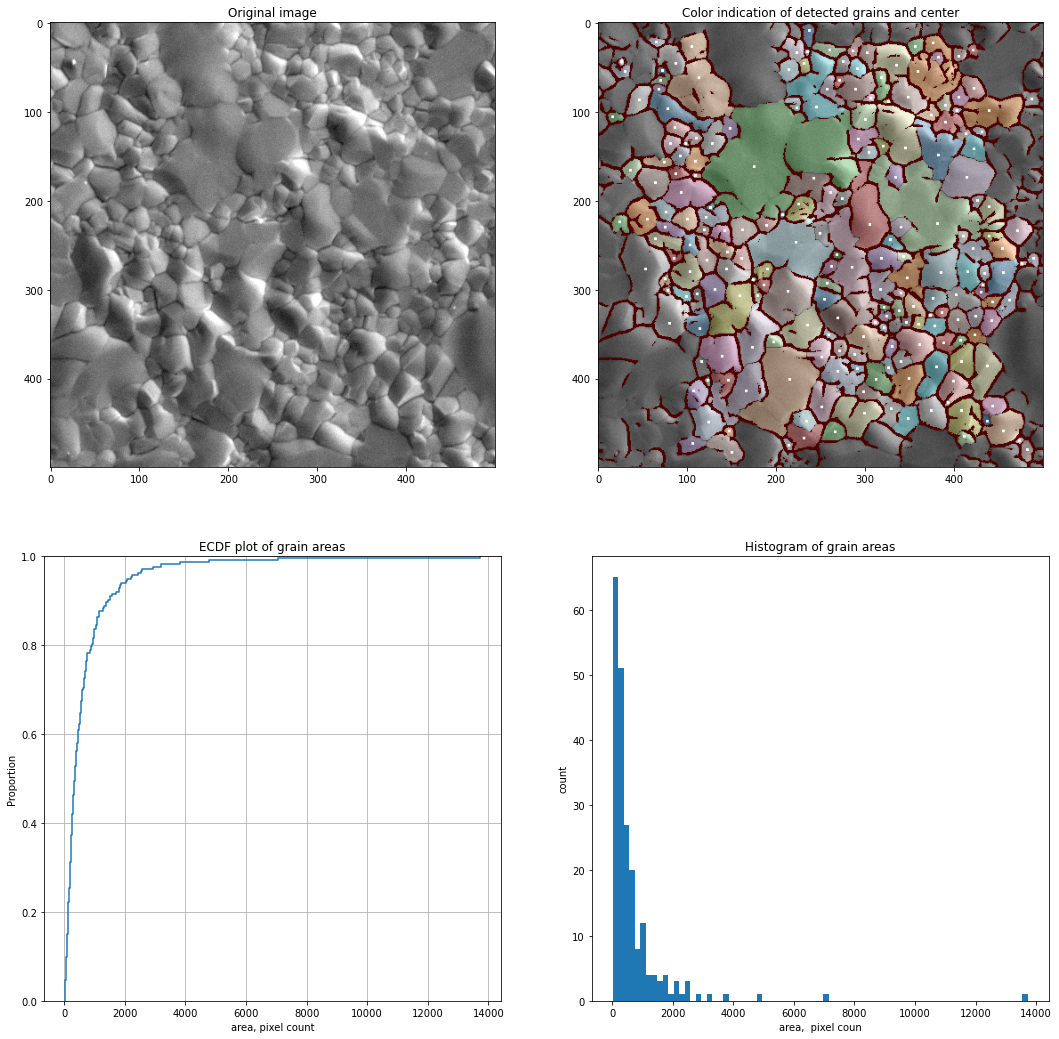

In [63]:
# test the approach on new pic
# new_img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 02.jpg", as_gray=True)[0:500, 0:500]
# new_img = img_as_float32(new_img)
# marked, mask_predicted = get_grain_borders(new_img)

grain_areas, pic = get_grains(new_img, mask_predicted)

# Conclusions
The proposed machine learning model and post processing are meeting the project goals. The next steps are to apply the algorithm to several hundreds of pictures and obtain the needed data insights. 

# Lessons learned
Domain knowledge
- labeled border thickness of 1 pixel is too small. The ML metrics are typically too poor. Probably due to high variation in the labels. 3 pixel thickness gives much better results. For the post processing the width could be reduced by application of skeletonization.
- shadows on the image have dominant direction and create false bias. For example the pixels in the bottom left corner are too important, but should not be. This bias is partially improved when using division as an input image, as shadow effects are significantly reduced. Further improvement is by applying image augmentation with rotations.
- production pictures come with variation in histograms. It is important to apply augmentation in the training data to improve production results.
- feature selection is very iterative task. The developer should focus on what data is actually provided to the algorithm and decide if it is enough or not. Review the pictures with high magnification to get an idea what the algorithms sees and what is needed to make a decision.
- It is impossible to achieve 100% accuracy, no matter how the features and model are tuned. It is important to invest time how to process the data so misclassifications affect the end goal as little as possible.
- The process of picture labeling is manual and involves errors. Contradictions are created by human, one cannot expect the model to solve them. The ground truth is not (and cannot be) 100% correct.

Handling large amounts of data
- use suitable data types; for example no need to convert and store a 256 bit image to float64. float32 (or even foat16) are better from resource point of view
- Working with features as type uint8 poses several risks:
    - if scaler is applied, production images can get out of the range
    - some image filters produce results greater than 255, and some less than 0
- XGboost has option single_precision_histogram = True, it created a what of problems when sample count approach 4_200_000 = ~ 2^22, with no warning. One could plot learning curve (score vs sample size) including points near the problematic threshold. The option reduces significantly the GPU memory usage and improves speed. Double check if you plan to use it in other research.
- PCA is not an option for so much data
- among ML algorithms only XGBoost runs in reasanable time. Running on GPU with CUDA support is much faster. The work was done on a machine with i7-9850H CPU, 32GB RAM and NVIDIA Quadro T100 (with CUDA) video card. The whole document (without the grid search) executes for about 20mins.

# References
This work would not be possible without several resources. Special acknowledge to:
- https://scikit-learn.org/stable/#
- https://scikit-image.org/
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/wksheets.htm
- https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w
- https://github.com/scikit-image/scikit-image/issues/4398
